<a href="https://colab.research.google.com/github/katearb/ipynb-projects/blob/master/w9_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime as dt
import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error as mse, r2_score, \
                            precision_score, recall_score, log_loss, \
                            accuracy_score as accuracy
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, BaseEstimator
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

import torch
import torch.optim as optim
from sklearn.base import TransformerMixin, BaseEstimator
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
from tf import keras
from keras import layers
from keras.utils.np_utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing import image_dataset_from_directory

import torchvision
import torchvision.transforms as transforms


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
tf.random.set_seed(0)

# Basic Part. Regression.

In [ ]:
data = pd.read_csv(r'https://raw.githubusercontent.com/katearb/files/main/AirQualityUCI_data.csv', sep=';', decimal=',')


## EDA (from "Regression 1" module, may be skipped)
#### Step 1. General information about the dataset

From the description, we can figure out that all our features are continuous, except for date and time.

In [ ]:
def draw_boxplot(data: pd.DataFrame,
                 column: str,
                 color: str='pink',
                 title: str=''):
    plt.figure(figsize=(10, 2), dpi=80)
    sns.boxplot(data=data[column], orient='h', color=color)
    plt.title(title)
    plt.xlabel('value')
    plt.show()

    return

In [ ]:
# explore data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB


In [ ]:
# explore some statistics
data.describe()

CO(GT)  PT08.S1(CO)  ...           RH           AH
count  9357.000000  9357.000000  ...  9357.000000  9357.000000
mean    -34.207524  1048.990061  ...    39.485380    -6.837604
std      77.657170   329.832710  ...    51.216145    38.976670
min    -200.000000  -200.000000  ...  -200.000000  -200.000000
25%       0.600000   921.000000  ...    34.100000     0.692300
50%       1.500000  1053.000000  ...    48.600000     0.976800
75%       2.600000  1221.000000  ...    61.900000     1.296200
max      11.900000  2040.000000  ...    88.700000     2.231000

[8 rows x 13 columns]

Observations:
1. In each column there are missed values, that's why the metrics are shifted.
2. In the column NMHC, the majority of the values are suspected to be Nans.

In [ ]:
# explore nan values
data.replace(-200, np.nan).isnull().sum().sort_values(ascending=False)

NMHC(GT)         8443
CO(GT)           1683
NO2(GT)          1642
NOx(GT)          1639
AH                366
RH                366
T                 366
PT08.S5(O3)       366
PT08.S4(NO2)      366
PT08.S3(NOx)      366
PT08.S2(NMHC)     366
C6H6(GT)          366
PT08.S1(CO)       366
Time                0
Date                0
dtype: int64

In [ ]:
# explore the phenomenon of "366 nan values in each column"
data[data['AH'] == -200].head(10)

Date      Time  CO(GT)  ...      T     RH     AH
524  01.04.2004  14.00.00     1.7  ... -200.0 -200.0 -200.0
525  01.04.2004  15.00.00     1.9  ... -200.0 -200.0 -200.0
526  01.04.2004  16.00.00     2.3  ... -200.0 -200.0 -200.0
701  08.04.2004  23.00.00     2.0  ... -200.0 -200.0 -200.0
702  09.04.2004  00.00.00     2.4  ... -200.0 -200.0 -200.0
703  09.04.2004  01.00.00     1.8  ... -200.0 -200.0 -200.0
704  09.04.2004  02.00.00     1.0  ... -200.0 -200.0 -200.0
705  09.04.2004  03.00.00     1.0  ... -200.0 -200.0 -200.0
706  09.04.2004  04.00.00     1.0  ... -200.0 -200.0 -200.0
707  09.04.2004  05.00.00     0.9  ... -200.0 -200.0 -200.0

[10 rows x 15 columns]

In [ ]:
len(data[data['AH'] == -200])

366

In [ ]:
# explore nan values in Co, No2 and Nox
data[data['CO(GT)'] == -200][data['NO2(GT)'] == -200][data['NOx(GT)'] == -200].head()

Date      Time  CO(GT)  PT08.S1(CO)  ...  PT08.S5(O3)     T    RH      AH
39   12.03.2004  09.00.00  -200.0         1545  ...         1588   9.2  56.2  0.6561
568  03.04.2004  10.00.00  -200.0         1418  ...         1410  19.7  43.3  0.9837
569  03.04.2004  11.00.00  -200.0         1410  ...         1372  20.7  41.7  1.0092
570  03.04.2004  12.00.00  -200.0         1438  ...         1266  23.3  35.8  1.0098
571  03.04.2004  13.00.00  -200.0         1278  ...         1014  23.8  30.5  0.8897

[5 rows x 15 columns]

In [ ]:
len(data[data['CO(GT)'] == -200][data['NO2(GT)'] == -200][data['NOx(GT)'] == -200])

1226

#### Assuptions:
1. NMHC(GT) has 90% nan values. As a result, the most sensible way to deal with this column is removal.
2. There are some samples where the majority of features are missed. If we try to fill them up with some statistics, this can lead to a distortion of the real situation, because most of theit features won't be 100% truth. Suggestion: as there are not so many of them (only 366 observations, which is near 4% of the total), I came up with deleting these rows.
3. As there are pretty many Nans in Co, No2 and Nox, some advanced tools will be applied for filling them up in Data Preparation section.


### Step 2. Univariate analysis

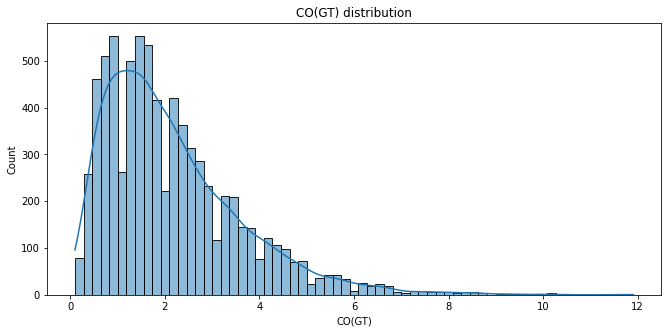

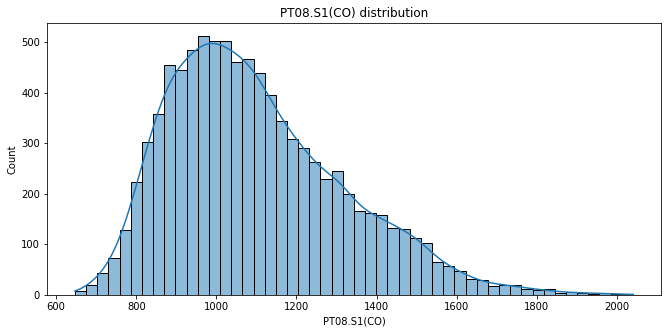

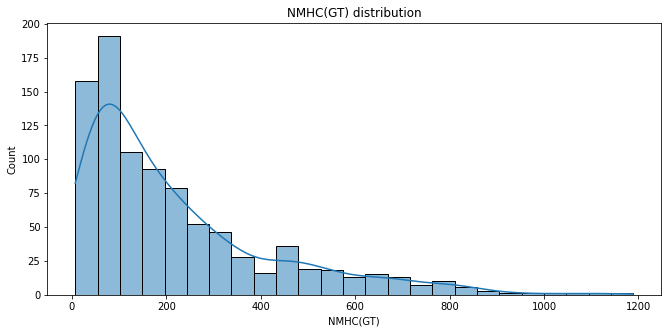

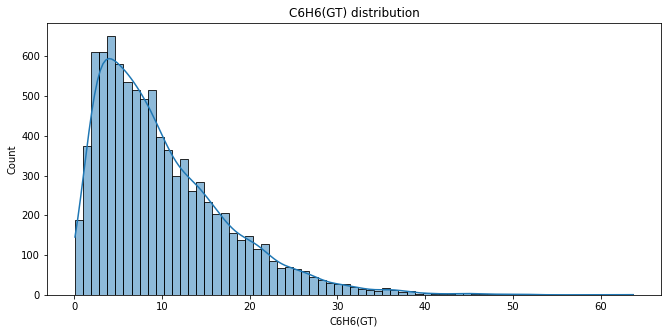

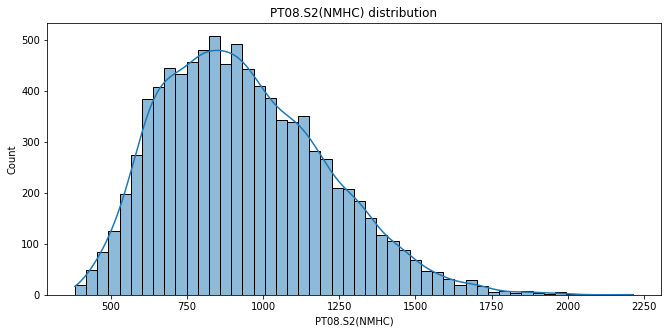

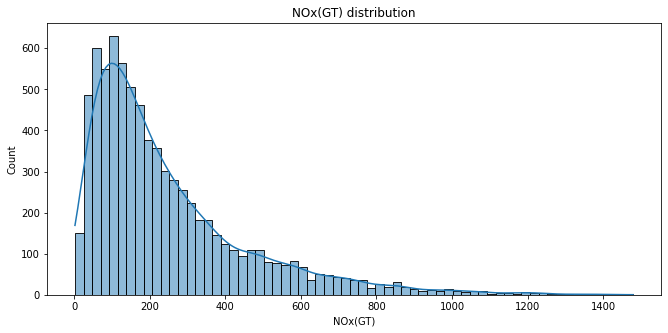

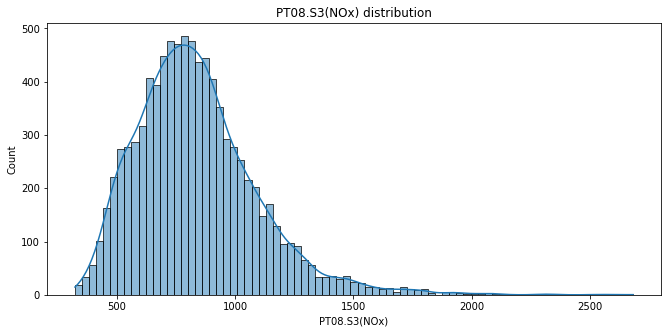

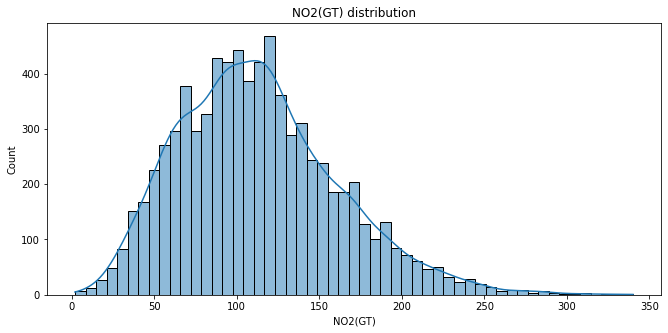

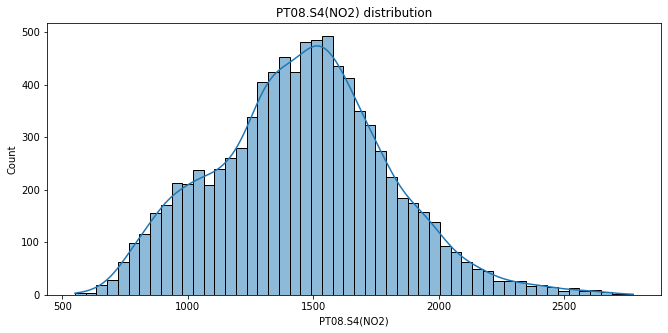

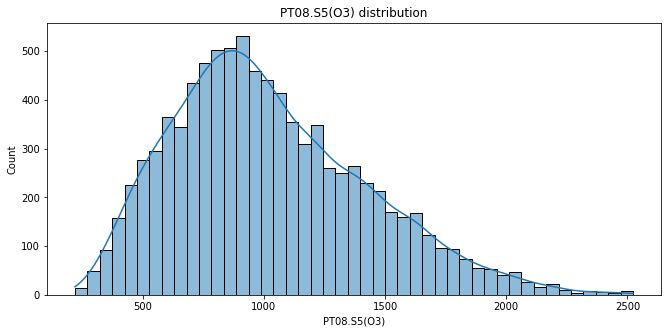

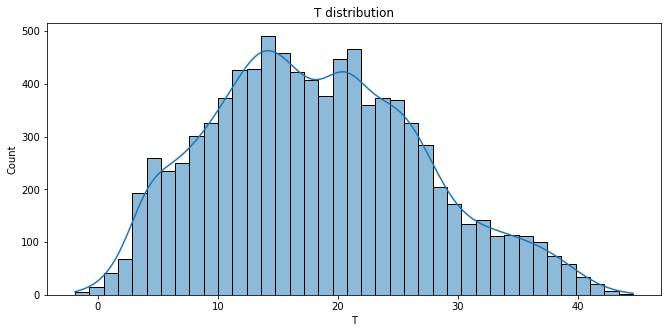

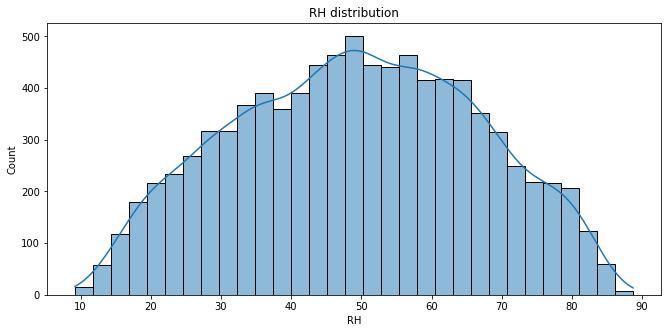

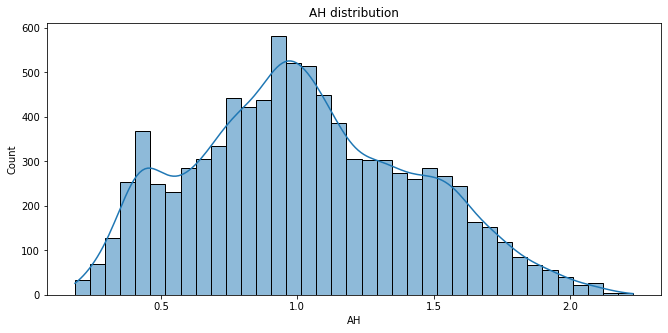

In [ ]:
# explore feature distribution excluding nan-values
for column in data.select_dtypes(exclude=np.object):
  data_hist = data.loc[data[column] != -200][column]
  plt.figure(figsize=(11, 5))
  sns.histplot(data_hist, kde=True)
  plt.title(f'{column} distribution')
  plt.show()

#### Observations:
1. Many features (all of them that represent chemical content values) are greatly positive skewed (outliers in high values can be detected).
2. All the features derivate from normal distribution, they have one mode (except temperature and absolute humidity: they have two)

In [ ]:
# creating dataset without nans for correct graphs
data_no_na = pd.read_csv(r'https://raw.githubusercontent.com/katearb/files/main/AirQualityUCI_data.csv', 
                         sep=';', decimal=',', na_values=-200).dropna()

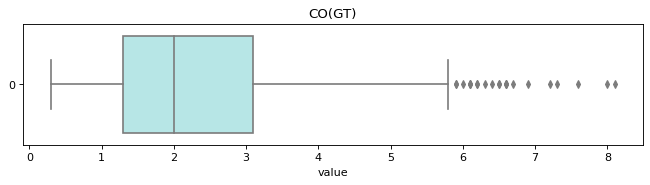

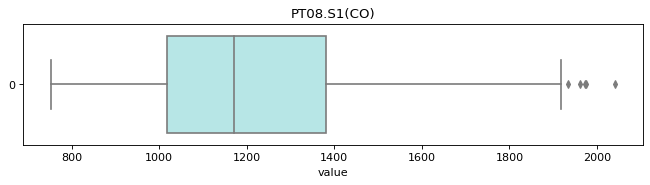

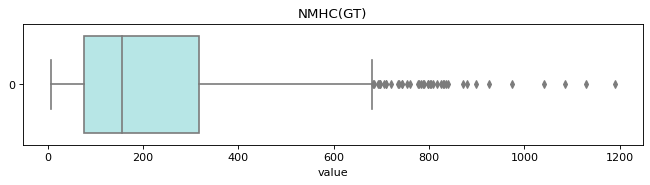

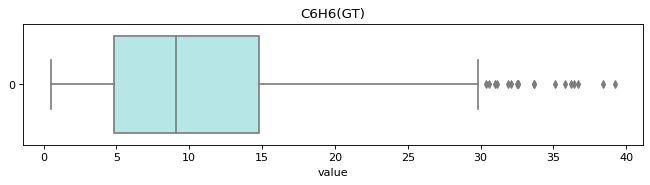

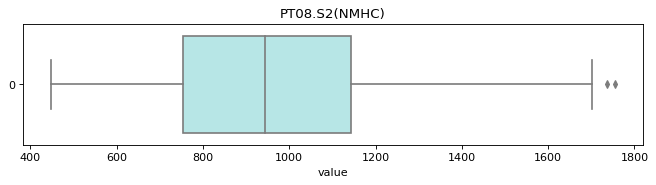

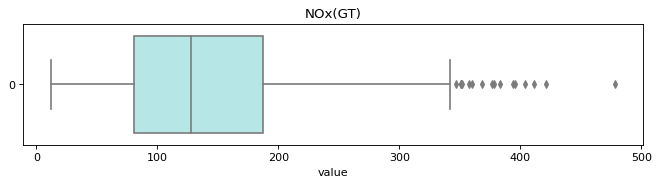

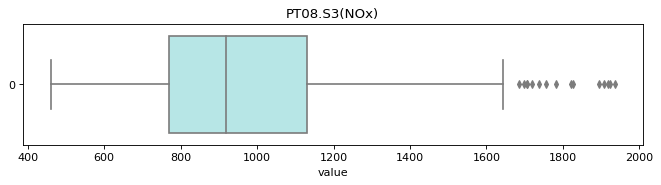

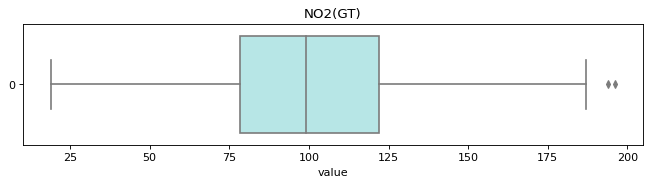

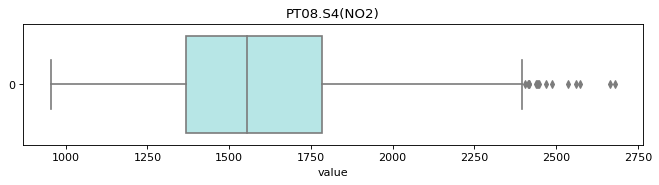

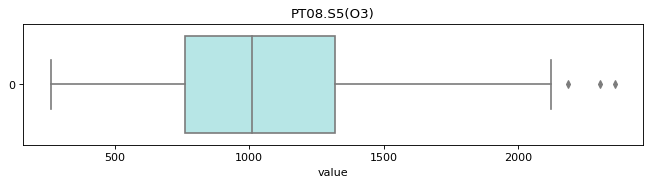

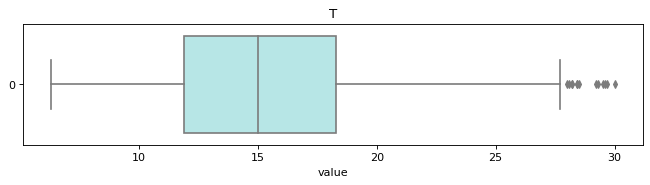

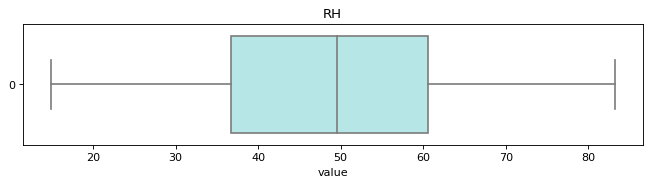

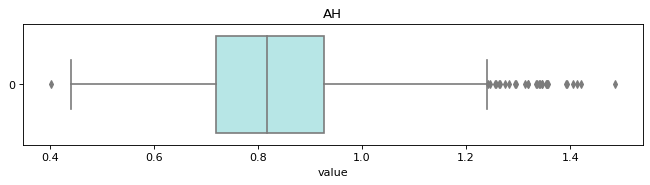

In [ ]:
# boxplot: vusualize outliers
for column in data_no_na.select_dtypes(exclude=np.object):
    draw_boxplot(data_no_na, column, 'paleturquoise', column)

As expected, outliers are detected on the right whiskers.

### Step 3. Multivariate analysis

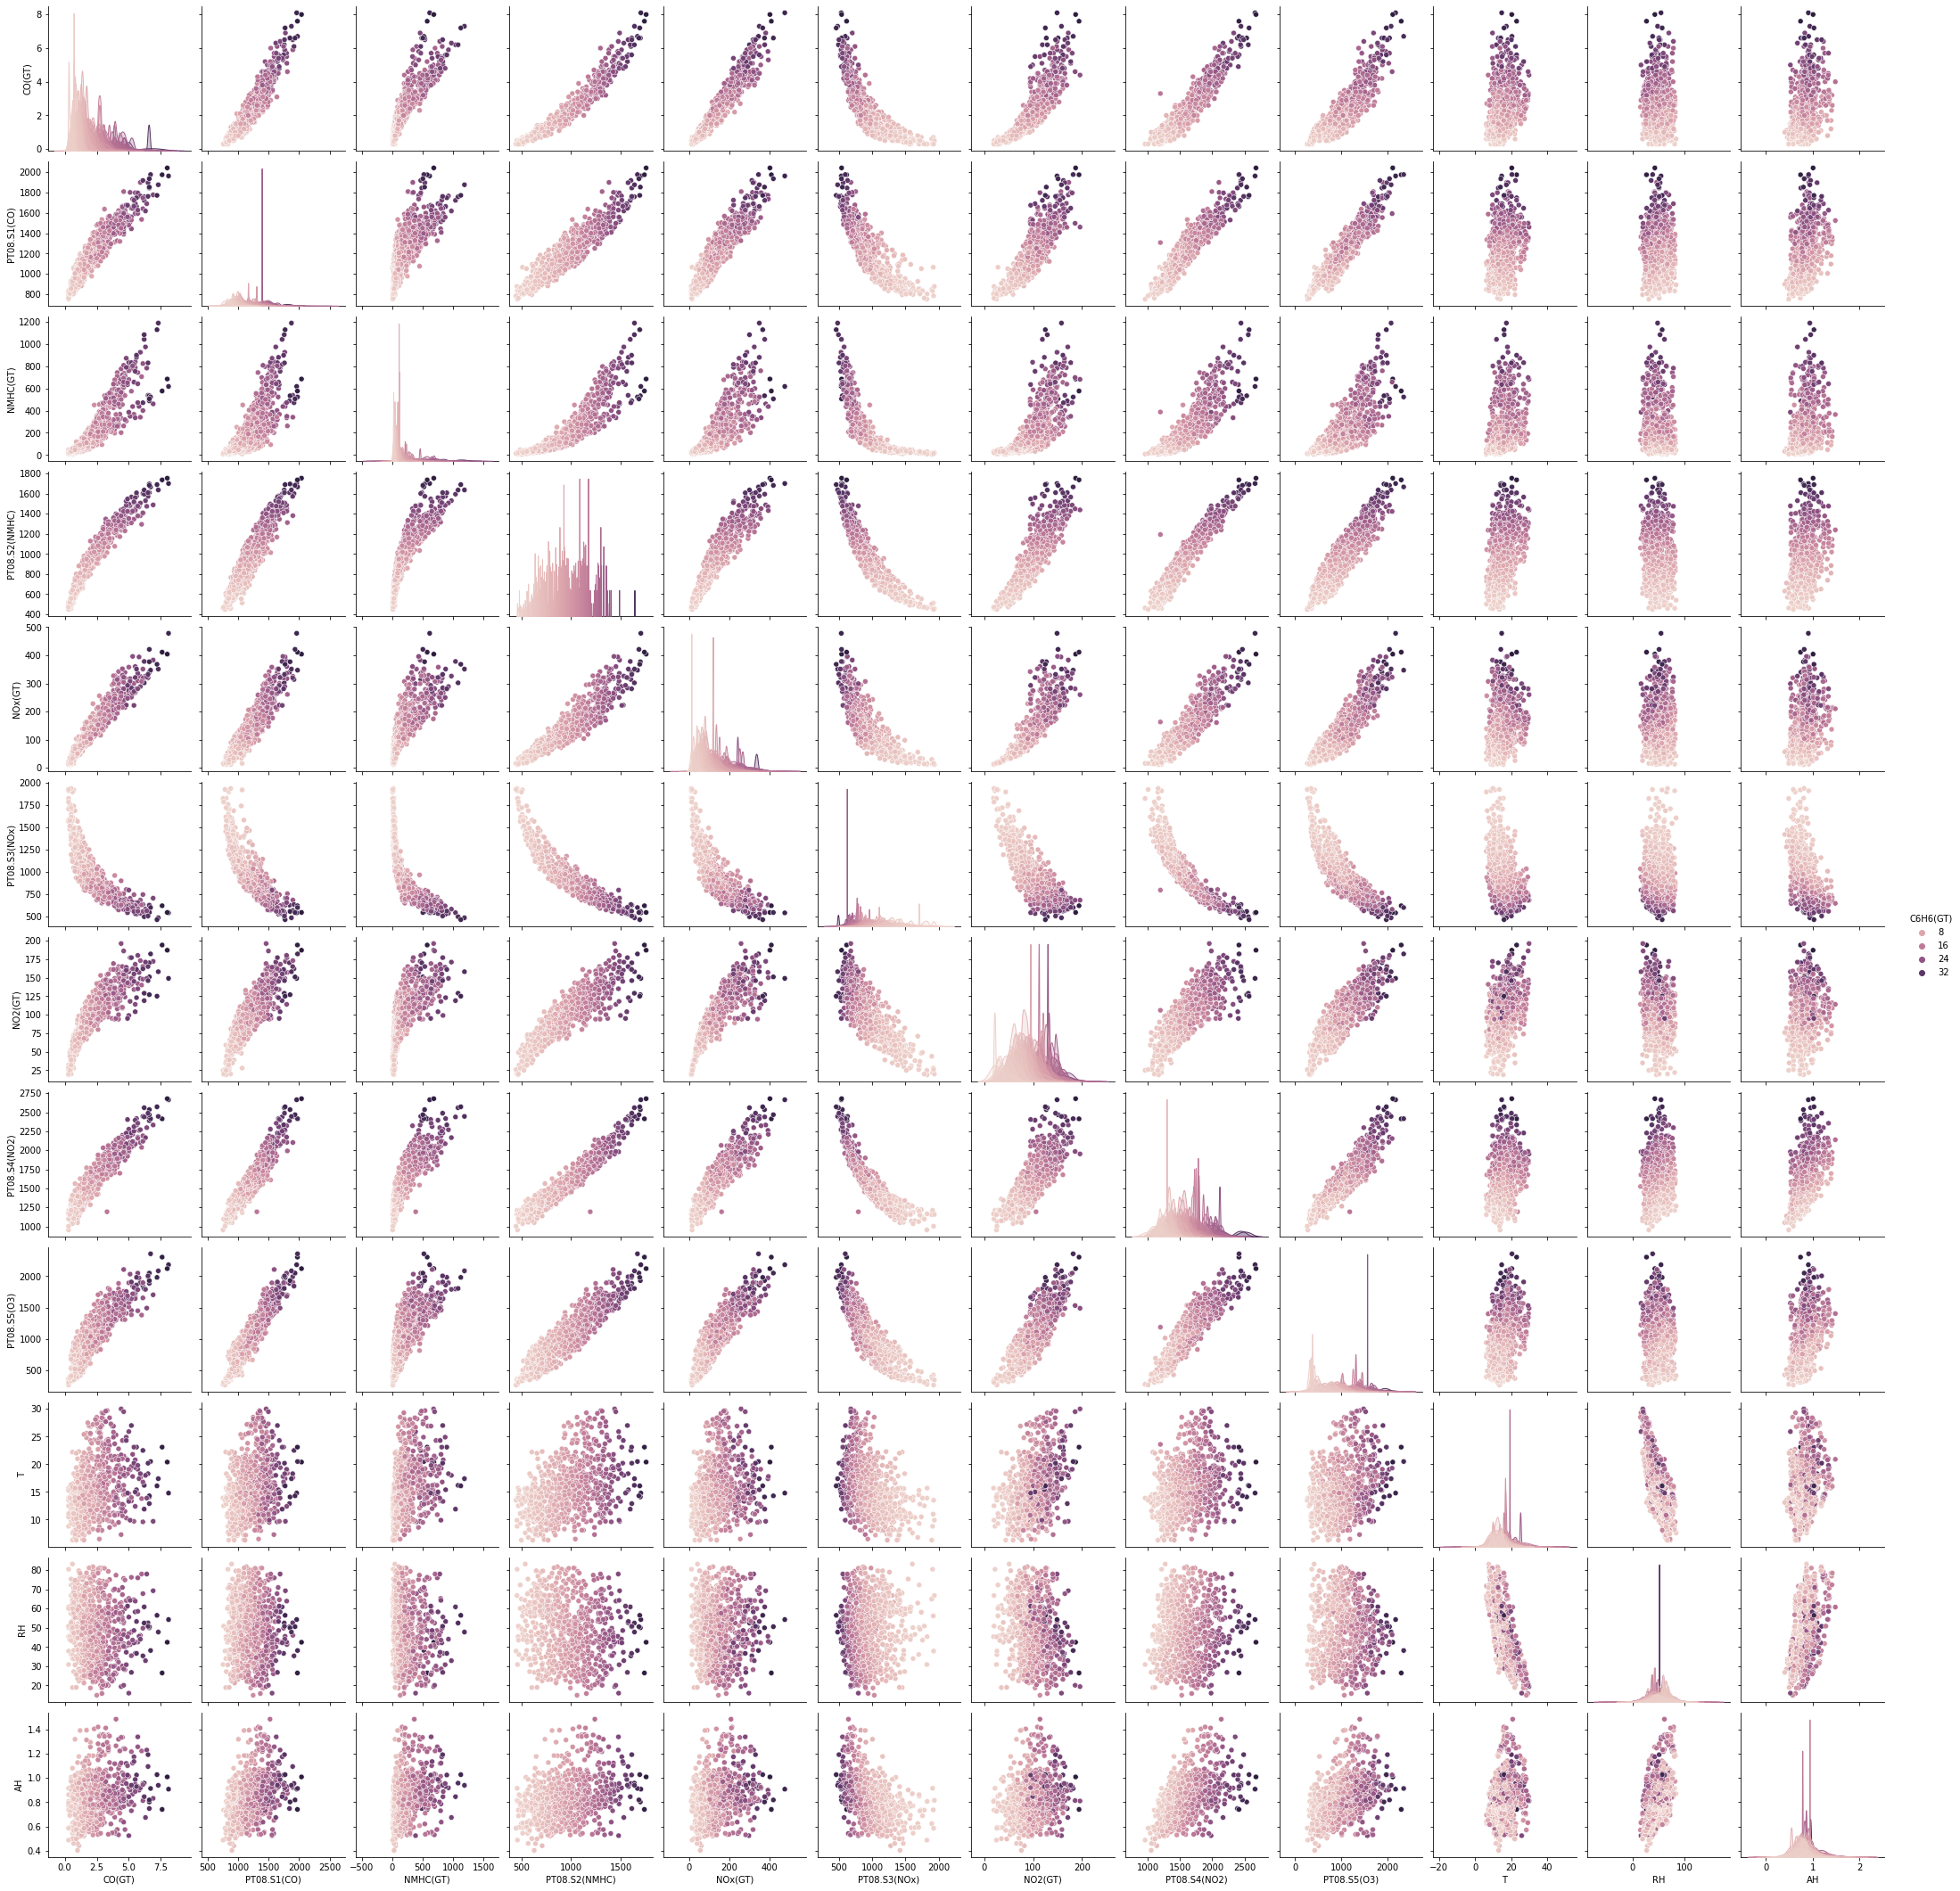

In [ ]:
#explore pair relations depending on the target
sns.pairplot(data_no_na, hue='C6H6(GT)')
plt.show()

#### Observations:
1. All chemical features are positive correlated with each other. The exeption is PT08.S3(Nox). The correlation between this feature and others is negative.
2.There is no correlation between chemical features and surrounding conditions.
3. There is correlation between all the features and the target.

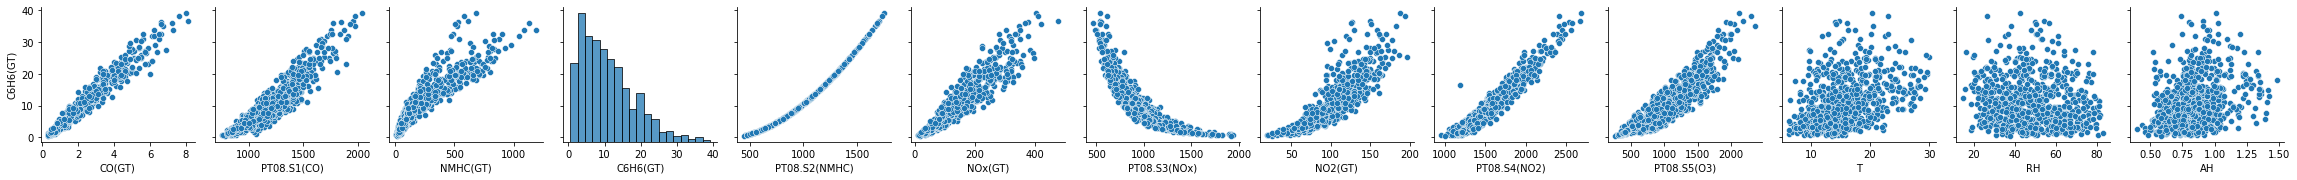

In [ ]:
# explore pair relations with the target
sns.pairplot(data_no_na, y_vars={'C6H6(GT)'})
plt.show()

The strongest correlation is observed between the target and PT08.S2, but correlations with other chemical features is very strong.

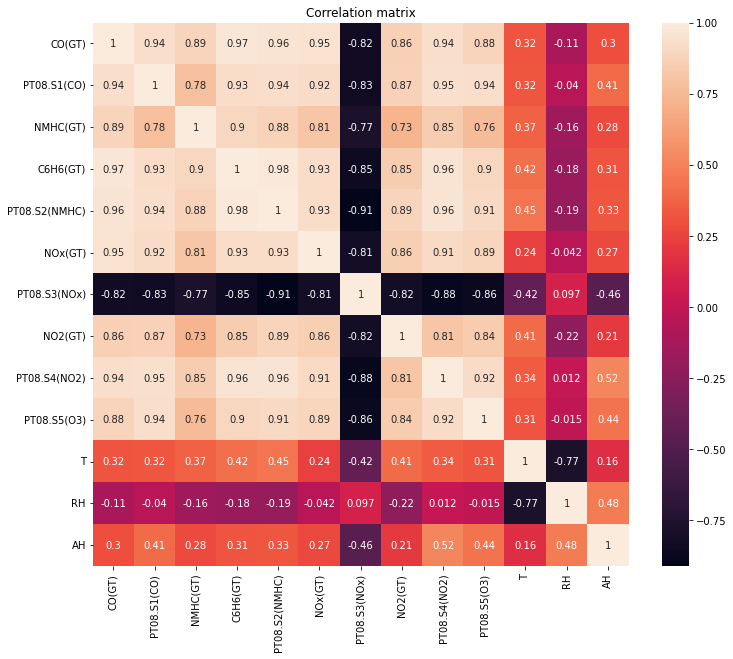

In [ ]:
# correlation matrix
data_corr = data_no_na.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(data_corr, annot=True)
plt.title('Correlation matrix')
plt.show()

#### Observations:
1. All chemical features are positive correlated to each other.An exception is PT08.S3. Its correlation with others is negative.
2.There is some positive (negative for PT08.S3) correlation between temperature and chemicals features, but it is not so strong.
3. The least correlated feature is relative humidity. Its strongest correlation is with temperature.
4. Traget: it is correlated to chemical features with almost 1 coefficient. Some correlation with temperature and absolute humidity is observed. There is no correlation to relative humidity.

Obviously, multicolinearity is a huuuuge problem in this dataset. There are some possible ways to deal with it:
1. We can use Dimensionality Reduction.
2. We can use lasso regularization, which will turn down some features to zero.

#### Data and Time features
There are two object-features^ date and time. We cannot use it in our model or even explore it properly.
I considered to find out whether there is some correlation between the target or given features and data/time. I suggested to alter date feature into numeric one by transforming it to Datetime-type first, and then change it to ordinal to be able to build a correlation matrix to see whether this feature is any usefull.

In [ ]:
# create numeric features out of date features
def create_new_features(df: pd.DataFrame):

  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
  df['Date'] = df['Date'].map(dt.datetime.toordinal)

  df['Hour'] = df['Time'].apply(lambda x: int(x.split('.')[0]))
  df.drop('Time', axis=1, inplace=True)

  return

In [ ]:
create_new_features(data)
create_new_features(data_no_na)

In [ ]:
data_corr_new = data_no_na.corr()

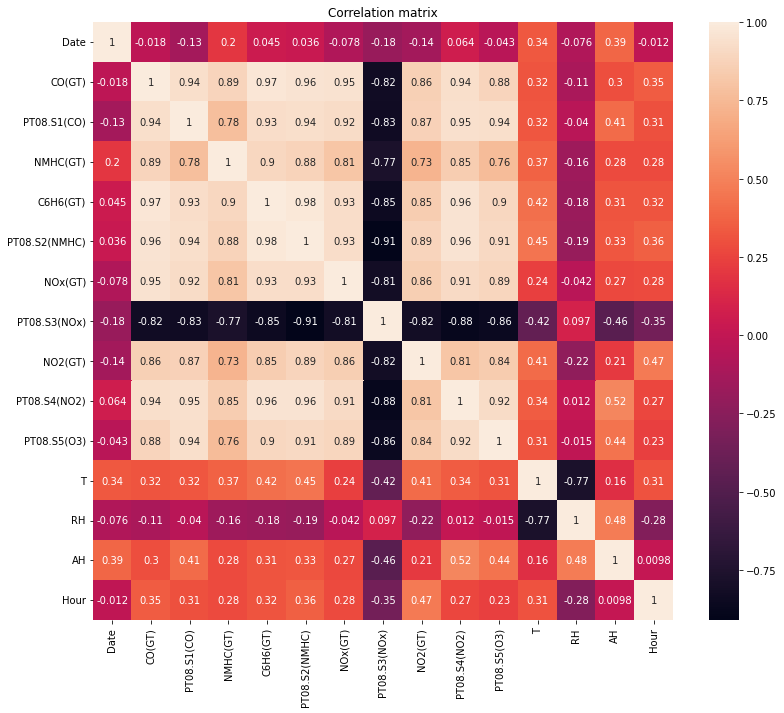

In [ ]:
plt.figure(figsize=(13, 11))
sns.heatmap(data_corr_new, annot=True)
plt.title('Correlation matrix')
plt.show()

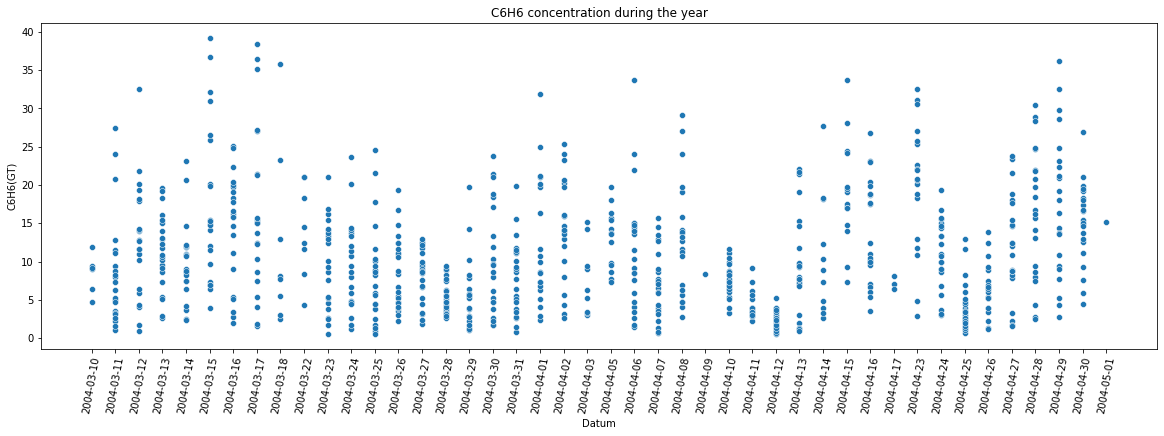

In [ ]:
plt.figure(figsize=(20, 6))
sns.scatterplot([str(dt.date.fromordinal(x)) for x in data_no_na['Date']], data_no_na['C6H6(GT)'])
plt.xticks(rotation=80)
plt.title('C6H6 concentration during the year')
plt.xlabel('Datum')
plt.show()

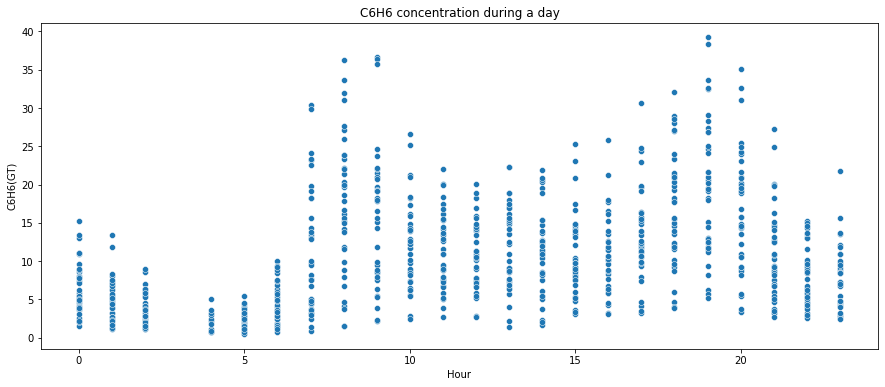

In [ ]:
plt.figure(figsize=(15, 6))
sns.scatterplot(data_no_na['Hour'], data_no_na['C6H6(GT)'])
plt.title('C6H6 concentration during a day')
plt.show()

There is no correlation between target and Date, but there is some with hour-feature. New features correlate also to some other except target.

On the scatter plot, we can see some tendencies depending on Hour feature -- it shows the relations between city's activity and emissions in the air: the concentration of C6H6 falls after 9pm and reaches the lowest level at 4-5am (at the night activity of the cuty and factories is the lowest). Then it is rising till 9am(when all people drive to their work). After that, it falls again till the lunch and increases till 7pm (when people's activity on the streets is high: they go home after work, go for a work, etc.). During the day, the concentration is still pretty high (higher than at night) because factories and manufactories are working.

On the scatter plot for the whole year, I can't really see any reasonable dependencies, but hour-feature prompted me to think about the dependence of the concentration of the substance depending on the activity of people in the city. Accordingly, this may be due to the fact that it is a weekday or a weekend in a particular sample.
I an going to create a new feature -- "weekday"/

In [ ]:
# create new feature
def create_weekday(df: pd. DataFrame):
  days = [dt.date.fromordinal(x) for x in df['Date']]
  wdays = {dt.datetime.toordinal(day): day.weekday() for day in days}
  df['Weekday'] = [wdays[day] for day in df['Date']]

  return

In [ ]:
create_weekday(data)
create_weekday(data_no_na)

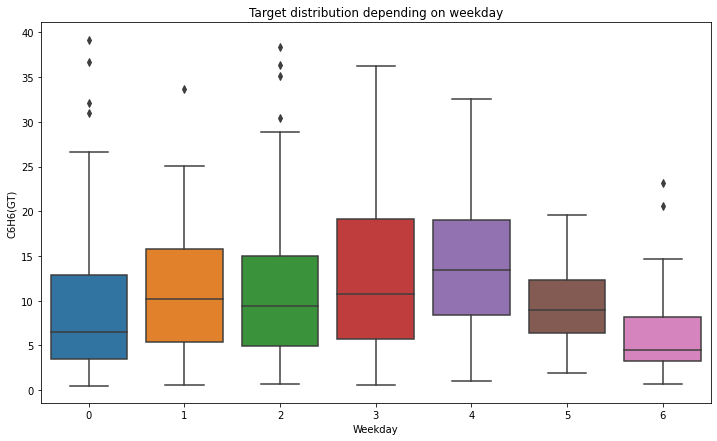

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(x=data_no_na['Weekday'], y=data_no_na['C6H6(GT)'])
plt.title('Target distribution depending on weekday')
plt.show()

Target distribution depending on a weekday


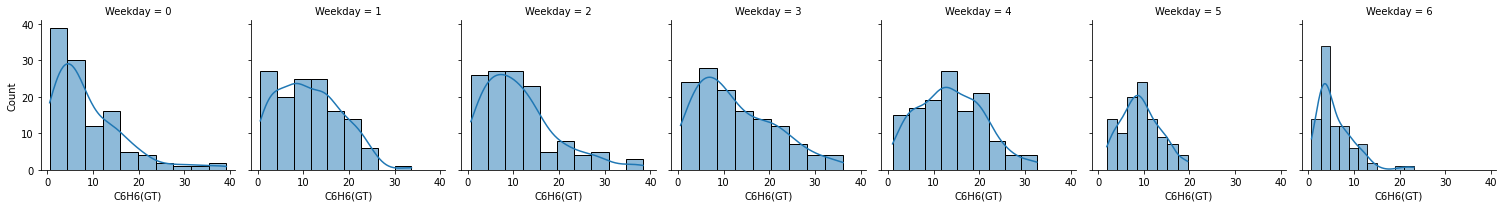

In [ ]:
g = sns.FacetGrid(data_no_na,  col="Weekday")
g.map(sns.histplot, "C6H6(GT)", kde=True)
print('Target distribution depending on a weekday')
plt.show()

To check, whether there is differences in target distribution dependent on weekday, I am going to use Kruskal-Wallis H Test, as the groups number is > 2 and they are not normal distributed.

In [ ]:
import scipy.stats as st
# Kruskal-Wallis H Test for 7 groups
mon = data[data['Weekday'] == 0]['C6H6(GT)']
tue = data[data['Weekday'] == 1]['C6H6(GT)']
wed = data[data['Weekday'] == 2]['C6H6(GT)']
thu = data[data['Weekday'] == 3]['C6H6(GT)']
fri = data[data['Weekday'] == 4]['C6H6(GT)']
sat = data[data['Weekday'] == 5]['C6H6(GT)']
sun = data[data['Weekday'] == 6]['C6H6(GT)']

stat, p = st.kruskal(mon, tue, wed, thu, fri, sat, sun)
print(f'stat={stat}, p={p}')
if p > 0.05:
	print('The same distribution')
else:
	print('Different distributions')

stat=467.6150182370812, p=7.92667051674069e-98
Different distributions


Not surprisingly, the distributions from day to day are different. Based on this results, I am going to keep this feature and delete "Date" later. "Hour" feature will be kept as well.

## Data preparation

In [ ]:
def timeseries_train_test_split(X, y, test_size):
    test_index = int(len(X)*(1-test_size))
    
    X_train = X[:test_index]
    y_train = y[:test_index]
    X_test = X[test_index:]
    y_test = y[test_index:]
    
    return X_train, X_test, y_train, y_test

# drop rows with many missing features (based on EDA)
def remove_missing(df: pd.DataFrame):
  return df[df['AH'] != -200]

In [ ]:
# drop NMHC(GT) column because of 90% missing values (based on EDA)
data_to_split = remove_missing(data)

In [ ]:
# data preprocessing
pipeline = Pipeline([
    ('impute', KNNImputer(missing_values=-200, n_neighbors=3)),
    ('scale', StandardScaler())
])

Two metrics will be used to evaluate models: one relative and one absolute:

* RMSE - absolute metric: easier to interpret (compared to mse), number of outliers is not huge (and in some cases I going to remove them), units of the targets are not large (from 0 to ~40).

* R2 -- relative metric(is independent of the data units of measurement), easy to interpret, helps us to understand whether our model is any good.

## PyTorch for regression

In [ ]:
def rmse(y: pd.core.series.Series,
         Y_pred: np.ndarray):
    return np.sqrt(mse(y, Y_pred))

# "scores" is a predefined dictionary
def evaluate_reg(true, pred, net=''):
  scores[net] = [rmse(true, pred), r2_score(true, pred)]


class PrepareRegData(Dataset):
  """
  Data preparation fpr PyTorch Regression Model
  """
  def __init__(self, X, y):
    X = pipeline.fit_transform(X) # feature transformation based on EDA
    if not torch.is_tensor(X):
      self.X = torch.from_numpy(X)
    if not torch.is_tensor(y):
      self.y = torch.from_numpy(np.array(y))

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]


class RegressionPyTorchNet(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(RegressionPyTorchNet, self).__init__()
    self.dense_h1 = nn.Linear(in_features=input_size, out_features=hidden_size)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.3)
    self.dense_h2 =  nn.Linear(in_features=hidden_size, out_features=hidden_size*2)
    self.dense_h3 =  nn.Linear(in_features=hidden_size*2, out_features=hidden_size//2)
    self.dense_out = nn.Linear(in_features=hidden_size//2, out_features=1)  

  def forward(self, X):
    x = self.relu(self.dense_h1(X))
    x = self.dropout(x)
    x = self.relu(self.dense_h2(x))
    x = self.relu(self.dense_h3(x))
    x = self.dense_out(x)
    return x


X = data_to_split.drop(['NMHC(GT)', 'Date', 'C6H6(GT)'], axis=1)
y = data_to_split['C6H6(GT)']

train, test = train_test_split(list(range(X.shape[0])), test_size=.2, shuffle=True) #indexes

ds = PrepareRegData(X, y=y)
train_set = DataLoader(ds, batch_size=48,
                       sampler=SubsetRandomSampler(train))

test_set = DataLoader(ds, batch_size=48,
                      sampler=SubsetRandomSampler(test))

net = RegressionPyTorchNet(13, 100)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adadelta(net.parameters(), lr=0.01)

About optimizers and lr selection for Pytorch and keras:

SGD: Pytorch works fine with with kind of optimizer, however could not reach the the results with any of the learning rates. In contrary, Keras had problems with SGD: by lr > 0.01, loss was nan, by any other lr loss was flactuated for training and was not optimized but was increasing for validation.

Adam: Pytorch also could not reach the best results.Keras was not stable.

Adadelta: for Pytorch, loss decreased veeery slowly by lr < 0.01. By lr = 0.01, loss decreses fast, stable and reaches the best result.

In [ ]:
# learning
for epoch in range(80):
  running_loss = 0.0
  for i, (inputs, labels) in enumerate(train_set, 0):
    inputs = inputs.float()
    labels = labels.float()

    # forward + backward + optimize
    outputs = net(inputs)
    outputs = outputs.view(-1)
    loss = criterion(outputs, labels)
    
    # zero the parameter gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss = loss.item()
    if i % 201 == 0:    
        print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss))
        running_loss = 0.0

print('Finished Training')

[1,     1] loss: 96.783
[2,     1] loss: 137.712
[3,     1] loss: 7.171
[4,     1] loss: 4.425
[5,     1] loss: 2.768
[6,     1] loss: 6.795
[7,     1] loss: 3.305
[8,     1] loss: 5.705
[9,     1] loss: 3.055
[10,     1] loss: 3.213
[11,     1] loss: 4.469
[12,     1] loss: 6.122
[13,     1] loss: 4.360
[14,     1] loss: 2.225
[15,     1] loss: 3.793
[16,     1] loss: 3.302
[17,     1] loss: 4.021
[18,     1] loss: 3.139
[19,     1] loss: 2.829
[20,     1] loss: 2.803
[21,     1] loss: 1.487
[22,     1] loss: 4.561
[23,     1] loss: 2.175
[24,     1] loss: 2.542
[25,     1] loss: 2.718
[26,     1] loss: 2.871
[27,     1] loss: 1.414
[28,     1] loss: 2.222
[29,     1] loss: 1.775
[30,     1] loss: 2.767
[31,     1] loss: 2.215
[32,     1] loss: 1.419
[33,     1] loss: 1.740
[34,     1] loss: 2.766
[35,     1] loss: 2.693
[36,     1] loss: 1.725
[37,     1] loss: 2.172
[38,     1] loss: 1.565
[39,     1] loss: 2.808
[40,     1] loss: 2.040
[41,     1] loss: 2.629
[42,     1] loss: 1.54

In [ ]:
# evaluation
preds_reg_torch = []
y_true_reg = []

net.eval()
with torch.no_grad():
  for samples, labels in test_set:
    samples = samples.float()
    labels = labels.float()

    outputs = net(samples)
    outputs = outputs.view(-1)
    
    preds_reg_torch.extend(list(outputs.detach().numpy()))
    y_true_reg.extend(list(labels.numpy()))

In [ ]:
scores = {}
evaluate_reg(y_true_reg, preds_reg_torch, 'PyTorch')

In [ ]:
scores

{'PyTorch': [1.2189469, 0.9730081598476903]}

## Keras for regression.

In [ ]:
def timeseries_train_test_split(X, y):
    
    X_train = X.iloc[train, :]
    y_train = y.iloc[train]
    X_test = X.iloc[test, :]
    y_test = y.iloc[test]
    
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y)

In [ ]:
# feature transformation
X_train_pr = pipeline.fit_transform(X_train)
X_test_pr = pipeline.fit_transform(X_test)

In [ ]:
# net with the same architecture as for PyTorch
def build_model():
  model = keras.Sequential([
    layers.Dense(100, activation='relu', input_shape=[13]),
    layers.Dropout(0.3),
    layers.Dense(200, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adadelta(0.01)

  model.compile(loss='mse', optimizer=optimizer)
  return model

In [ ]:
keras_net = build_model()

In [ ]:
EPOCHS = 180
history = keras_net.fit(
  X_train_pr, y_train, batch_size=48,
  epochs=EPOCHS, validation_split = 0.2, verbose=1)

Epoch 1/180
120/120 [==============================] - 1s 4ms/step - loss: 158.1067 - val_loss: 148.1894
Epoch 2/180
120/120 [==============================] - 0s 3ms/step - loss: 150.3958 - val_loss: 140.1564
Epoch 3/180
120/120 [==============================] - 0s 2ms/step - loss: 139.5662 - val_loss: 127.4551
Epoch 4/180
120/120 [==============================] - 0s 2ms/step - loss: 121.7671 - val_loss: 105.0681
Epoch 5/180
120/120 [==============================] - 0s 2ms/step - loss: 90.7415 - val_loss: 68.1424
Epoch 6/180
120/120 [==============================] - 0s 2ms/step - loss: 48.7068 - val_loss: 28.2404
Epoch 7/180
120/120 [==============================] - 0s 2ms/step - loss: 19.3736 - val_loss: 10.8891
Epoch 8/180
120/120 [==============================] - 0s 3ms/step - loss: 11.0898 - val_loss: 7.0985
Epoch 9/180
120/120 [==============================] - 0s 2ms/step - loss: 8.8180 - val_loss: 6.0628
Epoch 10/180
120/120 [==============================] - 0s 3ms/step 

In [ ]:
hist = pd.DataFrame(history.history)
hist.head()

loss    val_loss
0  158.106705  148.189362
1  150.395798  140.156448
2  139.566193  127.455055
3  121.767059  105.068115
4   90.741486   68.142426

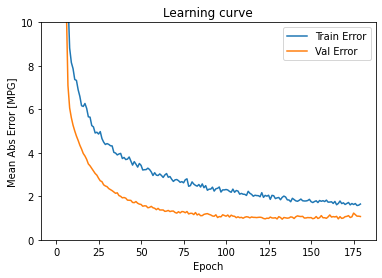

In [ ]:
def plot_history(history, y_lim=10):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  if list(hist.get('val_loss', [])):
    plt.plot(hist['epoch'], hist['val_loss'],
            label = 'Val Error')
  plt.ylim([0,y_lim])
  plt.legend()
  plt.title('Learning curve')
  plt.show()


plot_history(history)

In [ ]:
y_pred_peg_keras = keras_net.predict(X_test_pr)
evaluate_reg(y_test, y_pred_peg_keras, 'Keras')

## Comparison

In [ ]:
#drawing results of regression
def draw_residuals(true, pred):
  errors = np.array(true) - np.array(pred)

  plt.figure(figsize=(8, 5))
  plt.scatter(list(range(len(errors))),errors)
  plt.title("Distibution of errors")
  plt.ylabel('Error')
  plt.xlabel('Index')
  plt.show()

  plt.figure(figsize=(8, 5))
  plt.scatter(pred,errors)
  plt.title('Relationship of true value vs error (residual analysis)')
  plt.ylabel('Error')
  plt.xlabel('True value')
  plt.show()

  return

In [ ]:
y_pred_peg_keras = [x[0] for x in y_pred_peg_keras]

In [ ]:
pd.DataFrame(scores, index=['RMSE', 'R2']).T

RMSE        R2
PyTorch  1.218947  0.973008
Keras    1.317344  0.968475

                         =====PyTorch=====


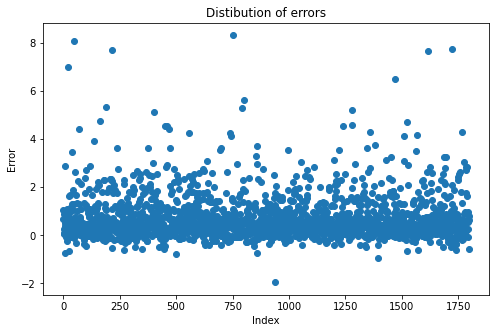

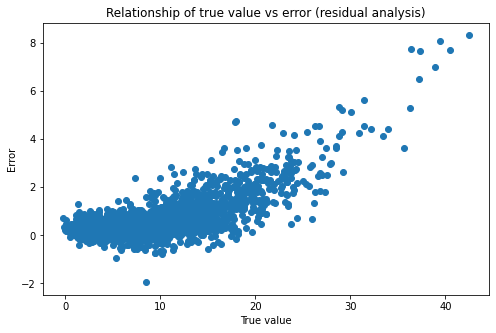

                           =====Keras=====


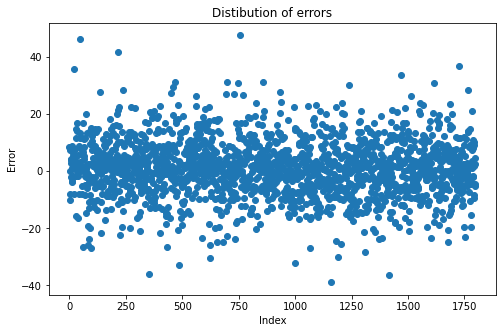

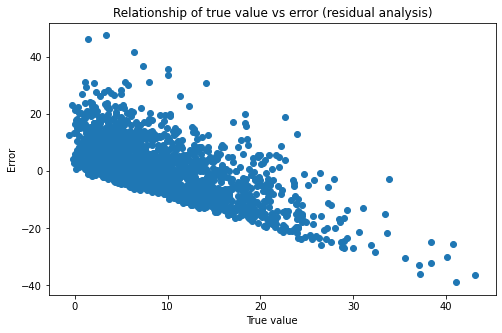

In [ ]:
print('                         =====PyTorch=====')
draw_residuals(y_true_reg, preds_reg_torch)
print('                           =====Keras=====')
draw_residuals(y_true_reg, y_pred_peg_keras)

#### Lasso regression from "Regression" module results

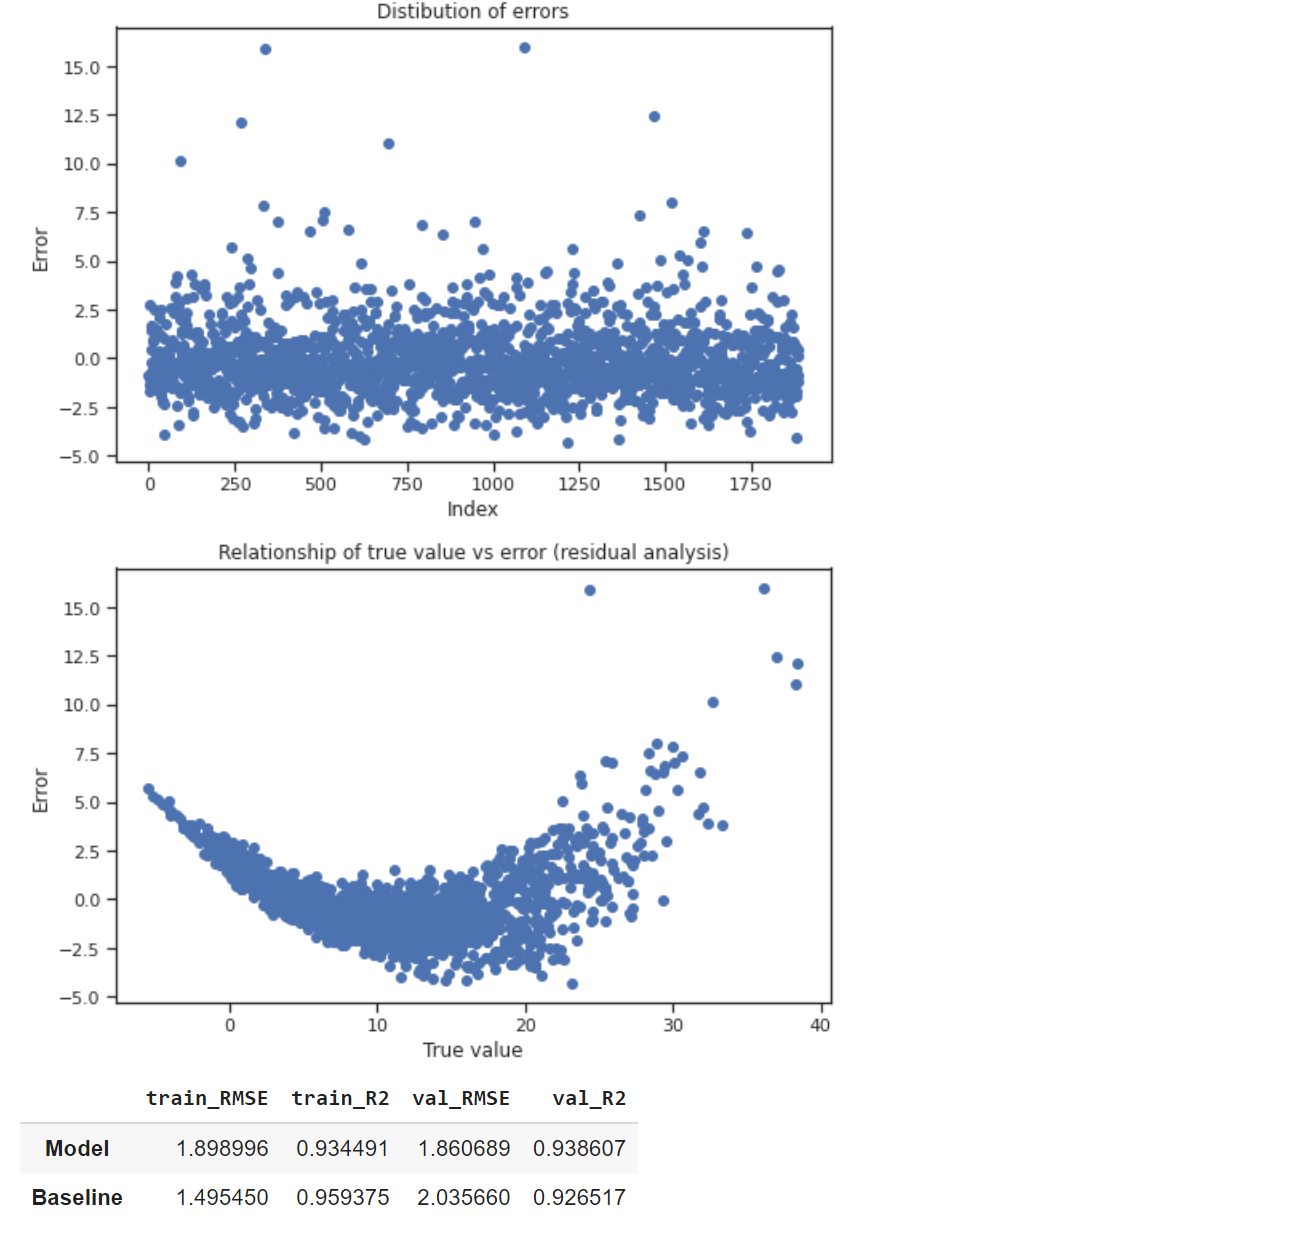

## Observations
PyTorch and Keras models were defined with the same architecture. However, they showed different results.
Number of layers was picked up experimentally. With any more layers, the models began to overfit a lot and could not reach such metrtics' values as with 1 hidden layer.

Pytorch model showed the best results compared to keras and some simple ML algorithmns from "Regression" module. On the picture in the row "Model", there are results of a Lasso regression with alpha = 0.001, data preprocessed with MinMaxscaler and Log transformation. "Baseline" is a linear regression with the same data preparation.

As we can see, nets show better results compared to simple regressions. The difference is not huge because there are a lot of correlated features in the data, so regressions' rerformance is high.

Residuals are also different. On Lasso regression's residual plots, outliers are observed.The residuals show quadratic pattern.This plot exhibit high heteroscedasticity.

The situation is different for PyTorch net. The residuals have  a positive trend here, but no heteroscedasticity or any polynomial pattern are detected.

Keras's residuals are, unfortunately, far away from "white noise". They show a negative trend. The range of residuals narrows down while true value increases.

# Basic Part. Classification.

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/katearb/files/main/dataset_hypothyroid.csv')

In [ ]:
# for graphs
data_no_na = pd.read_csv('https://raw.githubusercontent.com/katearb/files/main/dataset_hypothyroid.csv', na_values='?')
data_no_na = data_no_na.drop(['TBG', 'TBG_measured'], axis=1).dropna()

data_no_na is needed for EDA to draw graphs correctly, as it is problematic, for example, to build graph for numeric columns when there are NANs as it is impossible to convert to float/int types etc. It won't be used for modeling.

## EDA (from "Classification 1" module: may be skipped)

### step 1. General information about the dataset

In [ ]:
# define columns types and group them
numeric_columns = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
cat_column = 'referral_source'
target = 'Class'
bin_columns = [col for col in data.columns if (col not in numeric_columns) and col not in [cat_column, target]]
bin_columns_no_na =  [col for col in data_no_na.columns if (col not in numeric_columns) and col not in [cat_column, target]]
non_numeric = bin_columns + [cat_column] + [target]

# reverse mapping for the target
reverse_mapping = {0: 'negative', 
                   1: 'prim_hypothyroid', 
                   2: 'sec_hypothyroid',
                   3: 'comp_hypothyroid'}

In [ ]:
data.head()

age sex on_thyroxine  ... TBG referral_source     Class
0  41   F            f  ...   ?            SVHC  negative
1  23   F            f  ...   ?           other  negative
2  46   M            f  ...   ?           other  negative
3  70   F            t  ...   ?           other  negative
4  70   F            f  ...   ?             SVI  negative

[5 rows x 30 columns]

In [ ]:
data.shape

(3772, 30)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3772 non-null   object
 1   sex                        3772 non-null   object
 2   on_thyroxine               3772 non-null   object
 3   query_on_thyroxine         3772 non-null   object
 4   on_antithyroid_medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid_surgery            3772 non-null   object
 8   I131_treatment             3772 non-null   object
 9   query_hypothyroid          3772 non-null   object
 10  query_hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

All the features are represented by object-type, but from data.head() it gets clear that there are some numeric features, which could be represented by float or int (e.g. age or TSH).
* Changing data type is needed.

Most of the variables seem to be boolean and correspond to presens of a particular symptom, disease, or feature of the body.
* Encoding is needed.

In [ ]:
# make data type as it should be
# replace ? with -1 allows us to transform data type from object to int/float

def encode_binary(data: pd.DataFrame,
                  columns: list):
  for column in columns:
    if column == 'sex':
      data[column] = data[column].map({'M': 1, 'F': 0, '?': -1}).astype('int')
    else:
      data[column] = data[column].map({'t': 1, 'f': 0, '?': -1}).astype('int')

def encode_target(data: pd.DataFrame):
  data['Class'] = data['Class'].map({'negative': 0, 
                                     'primary_hypothyroid': 1, 
                                     'secondary_hypothyroid': 3,
                                     'compensated_hypothyroid': 2})
  
def type_numeric(data: pd.DataFrame,
                 columns: list):
  for column in columns:
    data[column] = data[column].replace('?', -1)

    if column == 'age':
      data[column] = data[column].astype('int')
    else:
      data[column] = data[column].astype('float')

# just calls encode_binary, type_numeric and encode_target functions 
# and returns modified dataset
def fix_datatype(data: pd.DataFrame,
                 bin_columns: list,
                 numeric_columns: list):
    new_data = data.copy()
    encode_binary(new_data, bin_columns)
    encode_target(new_data)
    type_numeric(new_data, numeric_columns)

    return new_data

In [ ]:
data_no_na = fix_datatype(data_no_na, bin_columns_no_na, numeric_columns)

### Step 2. Missing values.

In [ ]:
# count Nans
data.replace('?', np.nan).isnull().sum().sort_values(ascending=False)

TBG                          3772
T3                            769
T4U                           387
FTI                           385
TSH                           369
TT4                           231
sex                           150
age                             1
query_hypothyroid               0
I131_treatment                  0
thyroid_surgery                 0
pregnant                        0
on_antithyroid_medication       0
sick                            0
lithium                         0
query_on_thyroxine              0
on_thyroxine                    0
query_hyperthyroid              0
Class                           0
goitre                          0
tumor                           0
referral_source                 0
psych                           0
TSH_measured                    0
T3_measured                     0
TT4_measured                    0
T4U_measured                    0
FTI_measured                    0
TBG_measured                    0
hypopituitary 

In [ ]:
print('Number of samples with many Nans:', len(data[data['T4U'] == '?'][data['FTI'] == '?'][data['TSH'] == '?'][data['TT4'] == '?']))

Number of samples with many Nans: 203


Observations:
1. TBG feature is 100% missed --> delete on DP step.
2. T3 feature has ~20% missed values, which is a pretty big number. Taking into account that we have many features, it might be considered no to use this feature either if it doesn't improve prediction much.
3. In some other features, there are ~360 NANs, which is not enough to remove features, but still is too big for sample removal. The sets of observations with these omissions intersect, i.e. there are ~200 samples with many missing features.  --> impute on DP step.

### Step 3. Univariate analysis

### 3.1  explore values proportion of categorical features

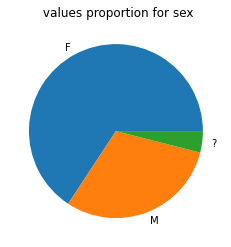

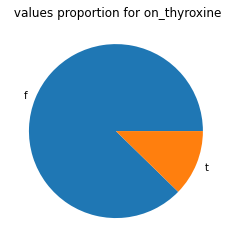

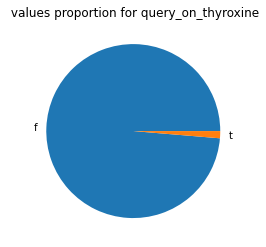

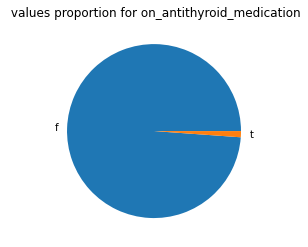

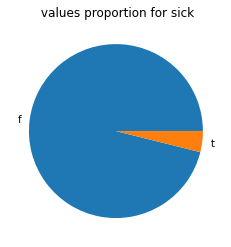

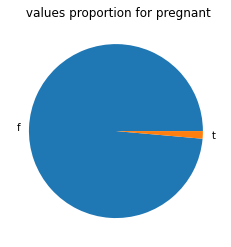

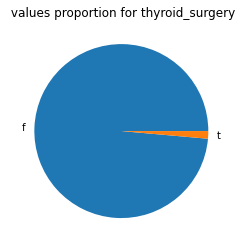

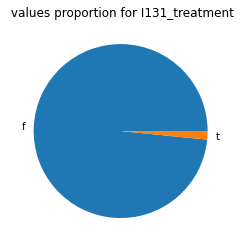

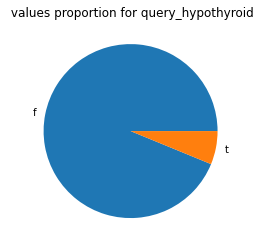

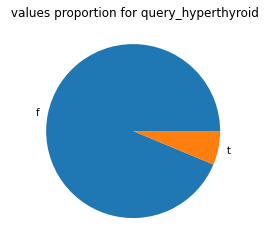

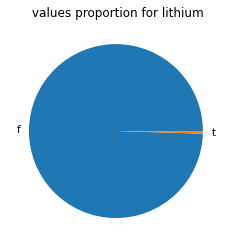

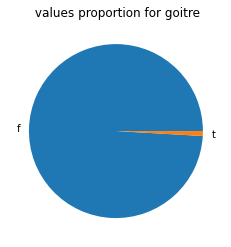

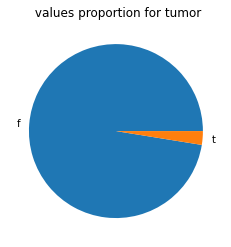

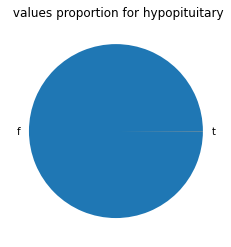

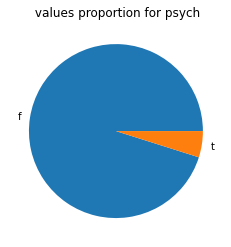

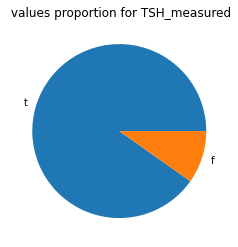

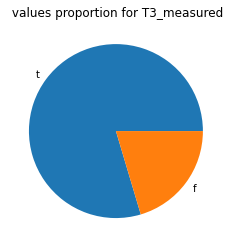

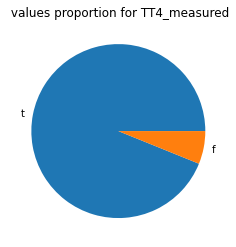

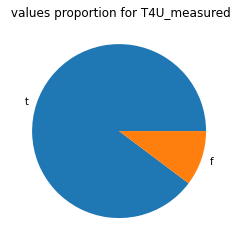

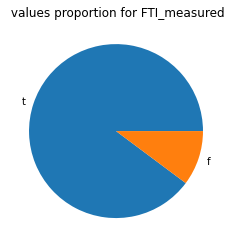

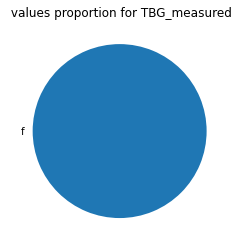

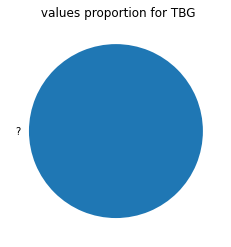

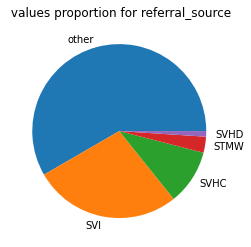

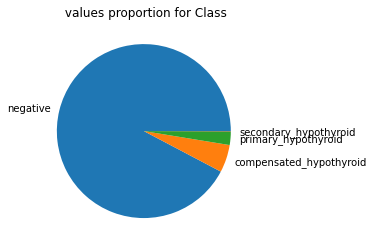

In [ ]:
for column in non_numeric:
  pie_info = data[column].value_counts()
  labels = pie_info.index
  plt.pie(pie_info, labels=labels)
  plt.title(f' values proportion for {column}')
  plt.show()

As many binary features have low variance, it might be considered to remove them better. However, even rare "t" values may be important for prediction non-negative classes. Let's look at the proportion of target values  while binary features = "t" and see whether it is more likely that they correspond to non-negative classes.

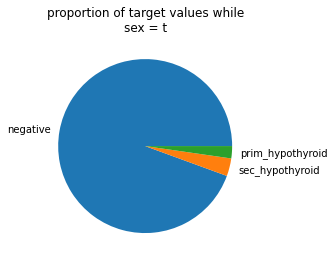

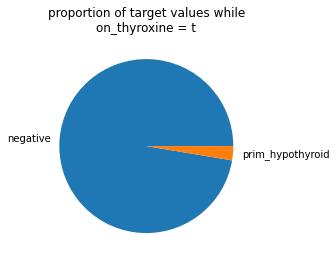

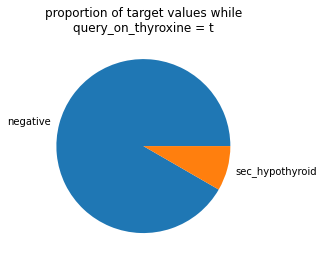

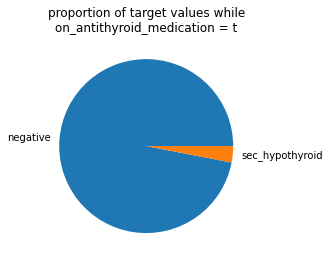

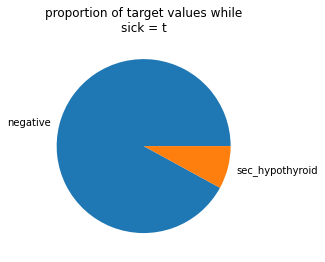

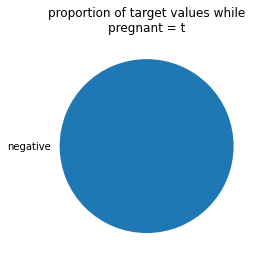

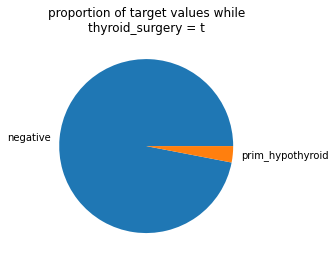

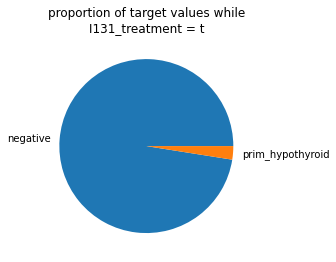

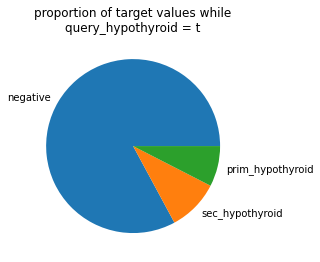

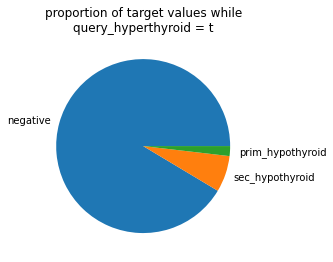

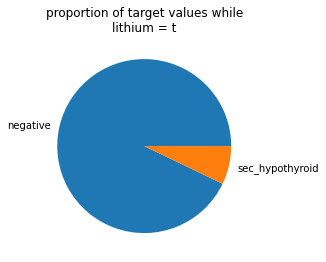

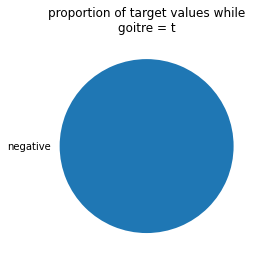

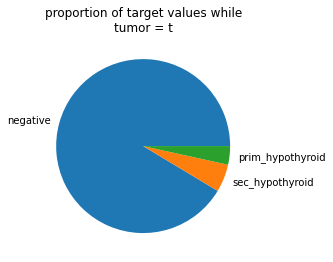

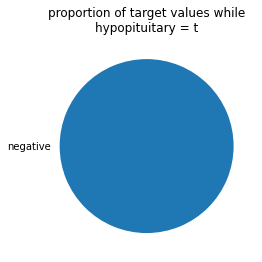

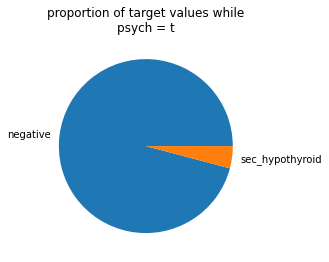

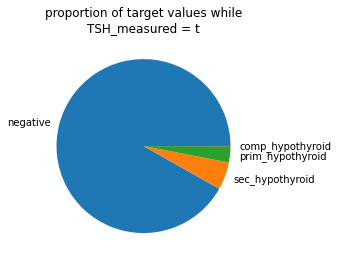

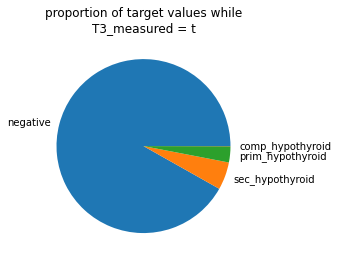

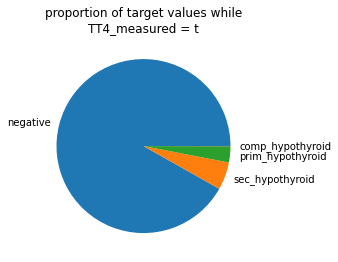

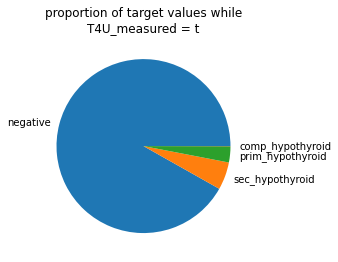

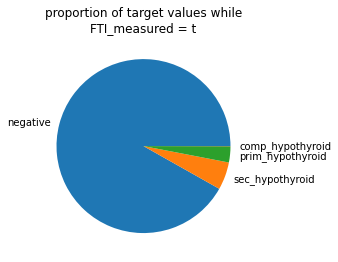

In [ ]:
for column in bin_columns_no_na:
  pie_info = data_no_na[data_no_na[column] == 1][target].value_counts()
  labels = pie_info.index.map(reverse_mapping)
  plt.pie(pie_info, labels=labels)
  plt.title(f'proportion of target values while\n{column} = t')
  plt.show()

Observations:
1. Here, we found why TBG is full of missed values. We see in TBG_measure that it wasn't just measured for any person --> TBG_measure turns out to be constant --> remove on DP step.
2.In all features, one of the variants ("f") prevails --> the values of the features are not balanced (same is for the target).We should pay attention to it while learning and evaluating model. Such dramatic disbalance will cause problems.

  Checking for target proportion didn't show that rare 't' values are strong signs of disease. (except, maybe, query_hypothyroid, where the proportion of non-negative classes is bigger compared to other features) --> We can use Variancethreshold to exclude low variance features. 
3. Hypopituitary seems also to be almost constant. Only one sample has 't' value. And it belongs to 'negative' target class, so if we remove this feature we won't lose any valued information about scanty target-classes. --> delete feature on DP step.


### 3.2 Explore statistics for numeric features

In [ ]:
data_no_na[numeric_columns].describe()

age          TSH  ...          T4U          FTI
count  2643.000000  2643.000000  ...  2643.000000  2643.000000
mean     53.081725     5.035978  ...     0.995650   109.435906
std      20.367966    23.974851  ...     0.196445    32.472156
min       1.000000     0.005000  ...     0.250000     2.000000
25%      37.000000     0.500000  ...     0.870000    93.000000
50%      55.000000     1.300000  ...     0.980000   107.000000
75%      69.000000     2.600000  ...     1.090000   124.000000
max     455.000000   530.000000  ...     2.120000   395.000000

[8 rows x 6 columns]

Some max values look like outliers or mistakes.

All features seem to be symetric because their means are close to the medians (except TSH: maybe there are many extreme outliers)

### 3.3 Explore distribution of numeric features

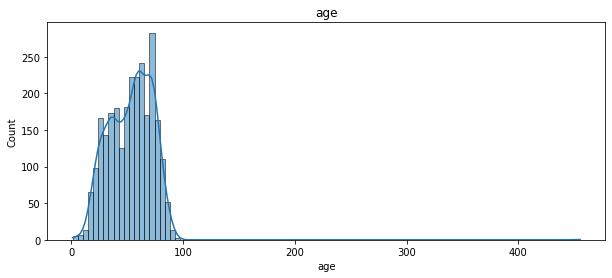

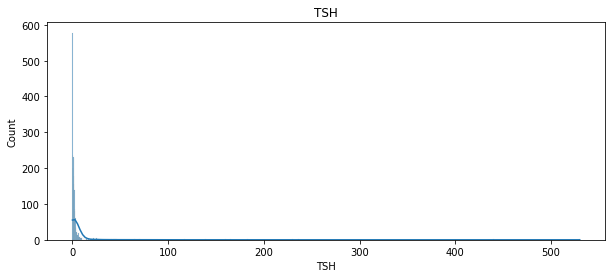

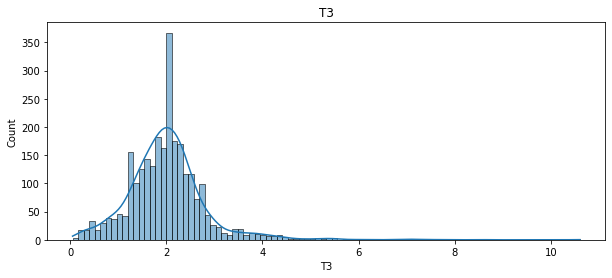

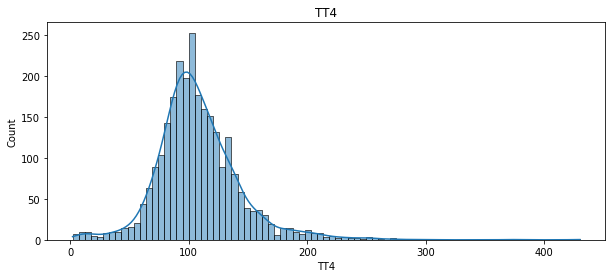

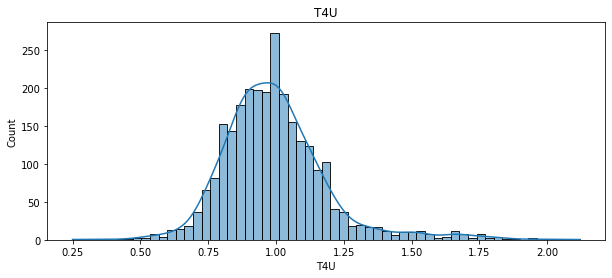

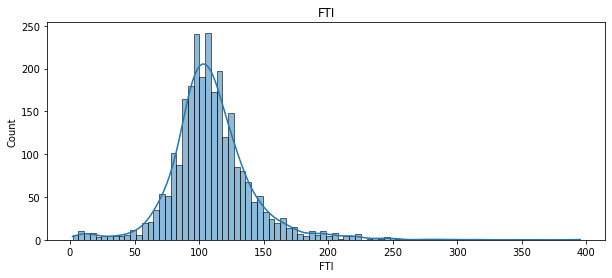

In [ ]:
for column in numeric_columns:
  data_hist = data_no_na[column]
  plt.figure(figsize=(10, 4))
  sns.histplot(data_hist, kde=True)
  plt.title(column)
  plt.show()

There are long tails in numeric featire distribution. That means there are some extreme values, which can negatively affect our model.

Age distribution seems to be symetric (if not to take into account extreme outliers) and has two modes.
T3, TT4, T4U and FTI distributions seem to be devote from normal distributed with positive kurtosis.

### 3.4. Outliers and Mistakes in numeric data

We should be very carefull when we want to delete any row. The reason is extreme disbalance in target classes. There some classes represented by very few samples. As a result, all these samples are truly valued.

Moreover, we are more interested in deviating values than in normal values as our main goal is to detect illness (i.e. deviating condition).

In [ ]:
def draw_pie(data: pd.DataFrame,
             column: str,
             upper_threshold: int or float = 0,
             lower_threshold: int or float = 0):
  
  if upper_threshold:
    pie_info = data[data[column] > upper_threshold]['Class'].value_counts() # threshold is choosen as it is the highest level of normal value according to the source
    labels = pie_info.index.map(reverse_mapping)
    plt.pie(pie_info, labels=labels)
    plt.title(f'Proportion of target classes for {column} > {upper_threshold}')
    plt.show()

  if lower_threshold:
    pie_info = data_no_na[data[column] < lower_threshold]['Class'].value_counts() # threshold is choosen as it is the lowest level of normal value according to the source
    labels = pie_info.index.map(reverse_mapping)
    plt.pie(pie_info, labels=labels)
    plt.title(f'Proportion of target classes for {column} < {lower_threshold}')
    plt.show()

  return

def draw_boxplot(data: pd.DataFrame,
                 column: str):
  plt.figure(figsize=(25, 3))
  sns.boxplot(data[column])
  plt.title(f'distribution of {column}')
  plt.show()

  return

def print_whiskers(feature: pd.Series):
  Q1 = np.percentile(feature, 25)
  Q3 = np.percentile(feature, 75)
  IQR = Q3 - Q1
  print(f'Left whisker: {Q1 - 1.5 * IQR}\nRight whisker: {Q3 + 1.5 * IQR}')

#### Feature "Age"

In [ ]:
data_no_na[data_no_na['age'] > 100]

age  sex  on_thyroxine  ...    FTI  referral_source  Class
1364  455    0             0  ...  104.0              SVI      0

[1 rows x 28 columns]

Obviously, age = 455 is a mistake in data. --> delete on DP step.

In [ ]:
data_no_na = data_no_na[data_no_na['age'] != 455]

#### Feature "TSH" (Thyroid StimulatingHormone)

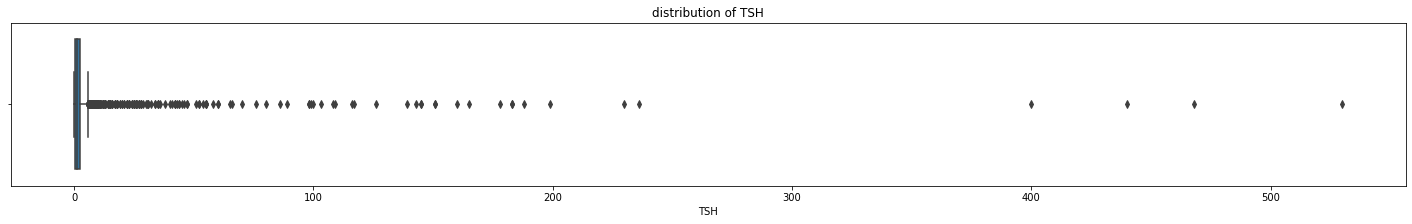

In [ ]:
draw_boxplot(data_no_na, 'TSH')

In [ ]:
# Quantiles
print_whiskers(data_no_na['TSH'])

Left whisker: -2.6500000000000004
Right whisker: 5.75


The range of the feature is pretty small and the range of the outliers is large.

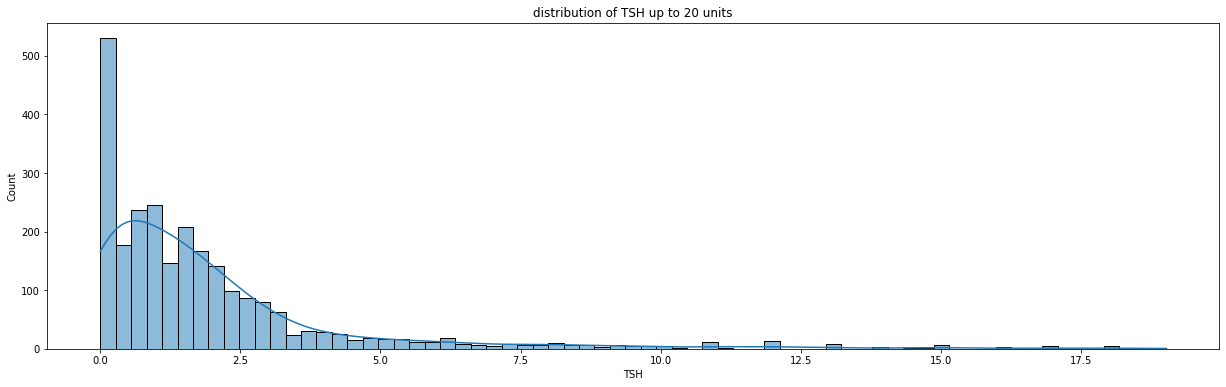

In [ ]:
plt.figure(figsize=(21, 6))
sns.histplot(data_no_na[data_no_na['TSH'] < 20]['TSH'], kde=True)
plt.title('distribution of TSH up to 20 units')
plt.show()

In the dataset discription, I didn't find what units of measurement were used, but after some internet research I can conclude that it is mIU/L (as most of the values are obseved in the range from 0 to ~5).
According to [this source](https://synlab.ee/ru/vrachu/laboratornyiy-spravochnik/interpretatsiya-rezultatov/immunologicheskie-issledovaniya/tireotropin-ili-gormon-stimuliruyushhiy-shhitovidnuyu-zhelezu-s-tsh/), normal value for TSH is 0.4-4.0 mIU/L and [for pregnant women and elderly people](https://newlab-med.ru/paczientam/kompleksyi-laboratornyix-issledovanij/laboratornaya-diagnostika-zabolevanij-shhitovidnoj-zhelezyi.html) up to 5.2 and 7.0 respectively. 
Unfortunately, I could not find what possible maximum value for TSH is, that's why we could not consider such large values as outliers, as it could be normal numbers for sickness. (And the next code cells prove it: the majority of target classes are not negative while TSH > 7).


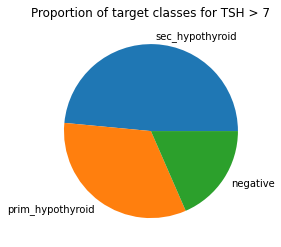

In [ ]:
draw_pie(data_no_na, 'TSH', 7)

As a result --> We keep all the values in dataset for TSH.

#### Feature "T3" (Triiodothyronine)

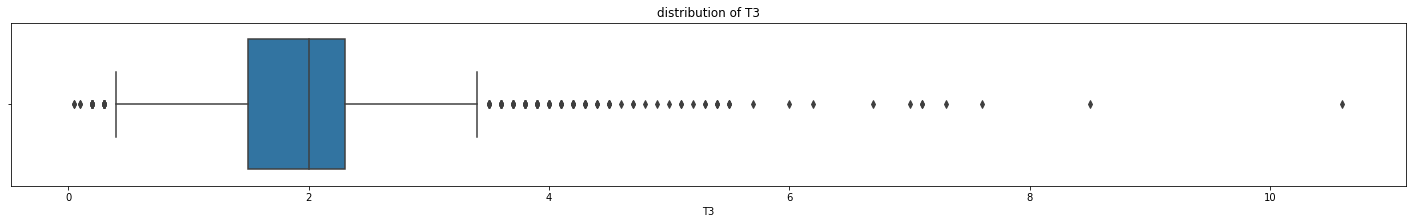

In [ ]:
draw_boxplot(data_no_na, 'T3')

Here, outliers' range is not so large as for TSH, but still there are some of them.
According to [this source](https://helix.ru/kb/item/08-113), the normal values are from 1 to 4 nmol/l; on our boxplot from ~0.3 to ~3.5.

In [ ]:
print_whiskers(data_no_na['T3'])

Left whisker: 0.30000000000000027
Right whisker: 3.4999999999999996


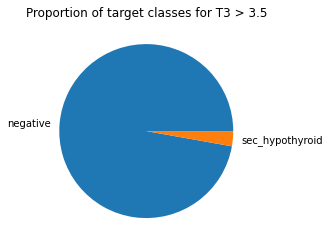

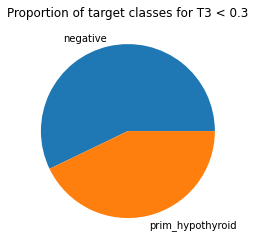

In [ ]:
draw_pie(data_no_na, 'T3', 3.5, 0.3)

 Interesting that while T3 is > 3.5 (which is out of the normal value), the target class is mostly negative. Low T3 may indicate sickness.

#### Feature "TT4" (Total Thyroxine)

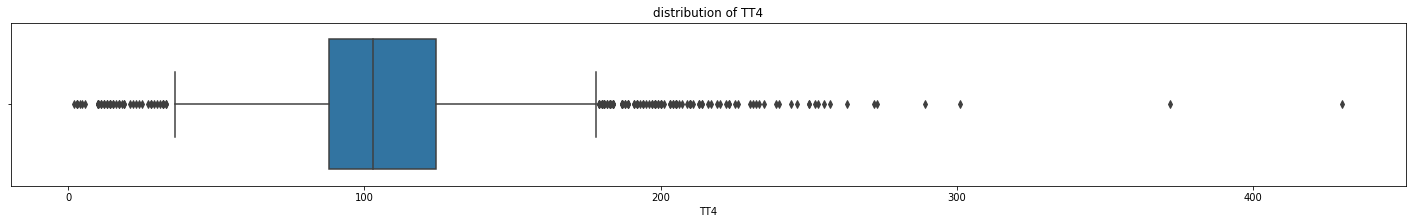

In [ ]:
draw_boxplot(data_no_na, 'TT4')

According to [this source](https://helix.ru/kb/item/08-115) normal values are 66 - 181 nmol/l. The range on our boxplot is nearly the same.

In [ ]:
print_whiskers(data_no_na['TT4'])

Left whisker: 34.0
Right whisker: 178.0


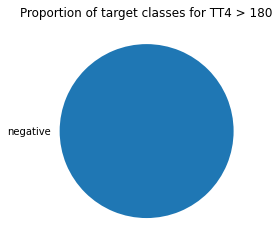

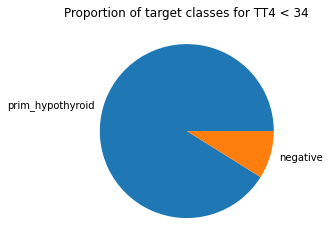

In [ ]:
draw_pie(data_no_na, 'TT4', 180, 34)

The target classes for TT4 > 180 are all negative, but fot TT4 < 50 the situation is opposite --> low TT4 is a sign of disease (and this is a valued information).

#### Feature "T4U" 

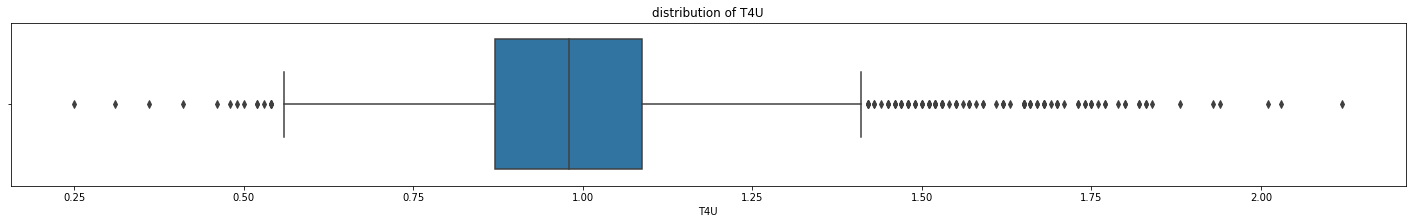

In [ ]:
draw_boxplot(data_no_na, 'T4U')

I could not find what "TU4" means and consider to establish "normal range" looking at the boxplot

In [ ]:
print_whiskers(data_no_na['T4U'])

Left whisker: 0.5437499999999997
Right whisker: 1.4137500000000003


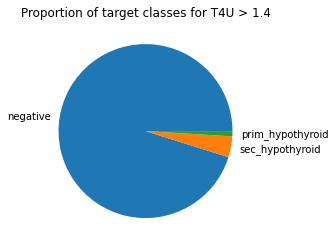

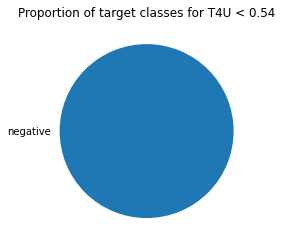

In [ ]:
draw_pie(data_no_na, 'T4U', 1.4, 0.54)

We can see some non-negative classes when T4U is low.

#### Feature "FTI" (The free T4 index)

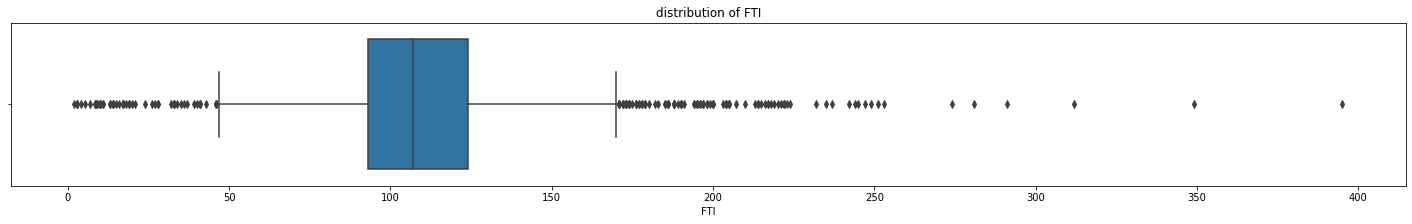

In [ ]:
draw_boxplot(data_no_na, 'FTI')

According to [it](https://www.verywellhealth.com/free-t4-index-procedure-4628291) the typical range for free T4 is between .8 and 1.8 nanograms per deciliter.
If we transform this feature by dividing by 100.

In [ ]:
data_no_na['FTI'] = data_no_na['FTI'].apply(lambda x: x / 100)

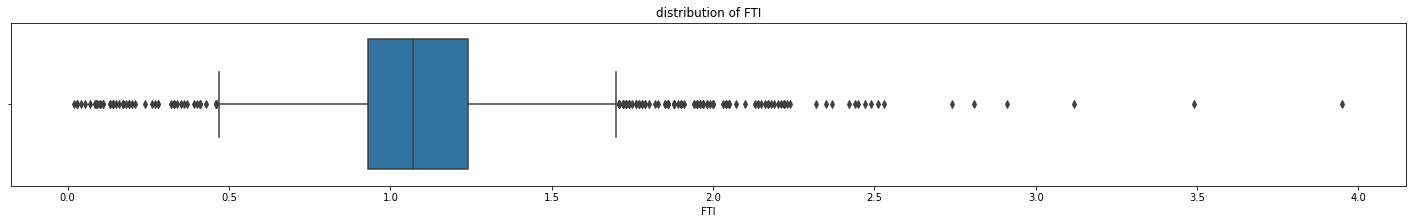

In [ ]:
draw_boxplot(data_no_na, 'FTI')

In [ ]:
print_whiskers(data_no_na['FTI'])

Left whisker: 0.46500000000000014
Right whisker: 1.7049999999999998


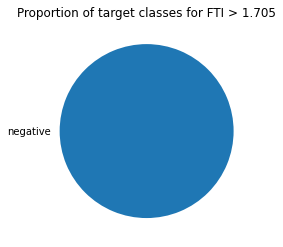

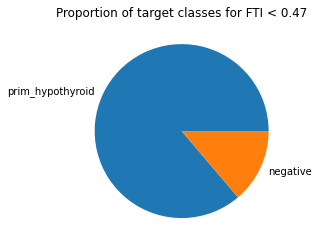

In [ ]:
draw_pie(data_no_na, 'FTI', 1.705, 0.47)

Low FTI is a sign of primary hypothyroid.

### Step 4. Multivariative analysis

### 4.1 pair relations

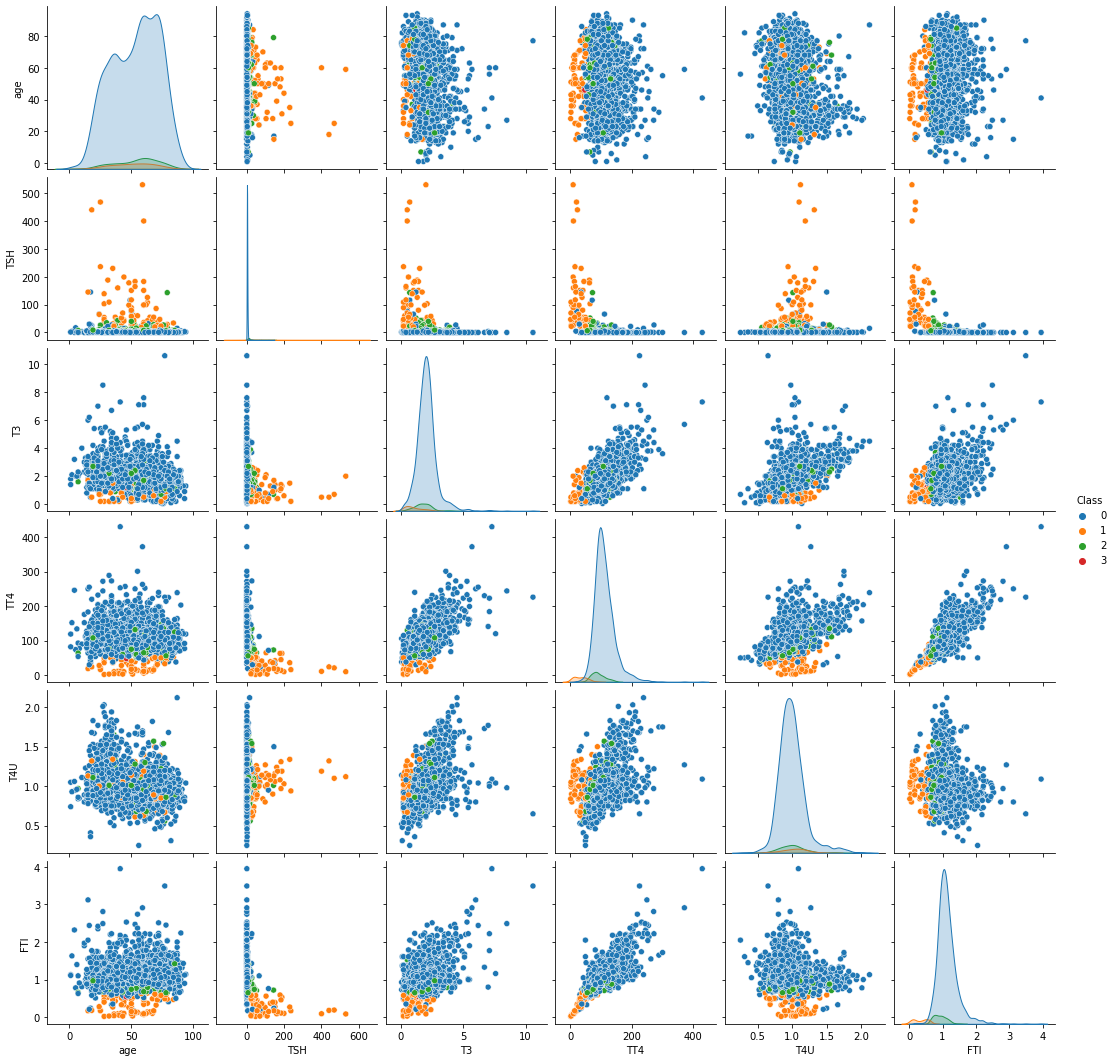

In [ ]:
sns.pairplot(data_no_na[numeric_columns + [target]], hue='Class', palette='tab10')
plt.show()

We see that on some plots target classes are well distinguishable. Especially, primary hypothyroid (labek 1) is visually separated from two others. (e.g. in FTI or TSH rows). The compensated hypothyroid (label 3) is really mixed uo with negative class (label 0). I expect that it will be very difficult for the model to distinguish it.

### 4.2 correlation within numeric features

In [ ]:
data_corr = data_no_na[numeric_columns].corr()

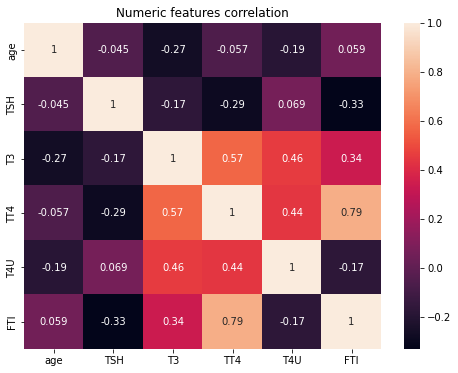

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(data_corr, annot=True)
plt.title('Numeric features correlation')
plt.show()

Multicolleration is observed. We can see the strongest correlation between FTI and TT4. It can be explaned as FTI is Index of FTI.

The correlation between TT4 and T3 is also > 50.

### 4.3 dependency of binary features and the target

As we need to find out correlation between non-negative boolean and categorical features, we are going to use [chi2](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html)

H0 - target and the column are independent

H1 - target and the column are dependent

In [ ]:
from scipy.stats import chi2_contingency
dependency = []
for column in bin_columns_no_na:
  _, p, _, _ = chi2_contingency(pd.crosstab(data_no_na[column], data_no_na[target]))
  if p < 0.05:
    dependency.append([p, '+++', 'reject H0: dependent'])
  else:
    dependency.append([p, '---', 'fail to reject H0: independent'])
dependency_res = pd.DataFrame(dependency, columns=[ 'p', 'status', 'comment'])
dependency_res.index = bin_columns_no_na

In [ ]:
dependency_res

p status                         comment
sex                        0.005953    +++            reject H0: dependent
on_thyroxine               0.000915    +++            reject H0: dependent
query_on_thyroxine         0.750377    ---  fail to reject H0: independent
on_antithyroid_medication  0.705709    ---  fail to reject H0: independent
sick                       0.145061    ---  fail to reject H0: independent
pregnant                   0.294771    ---  fail to reject H0: independent
thyroid_surgery            0.608564    ---  fail to reject H0: independent
I131_treatment             0.516135    ---  fail to reject H0: independent
query_hypothyroid          0.000440    +++            reject H0: dependent
query_hyperthyroid         0.636553    ---  fail to reject H0: independent
lithium                    0.910766    ---  fail to reject H0: independent
goitre                     0.616178    ---  fail to reject H0: independent
tumor                      0.995636    ---  fail to reject H0: independent
hypopituitary              0.993116    ---  fail to reject H0: independent
psych                      0.102191    ---  fail to reject H0: independent
TSH_measured               1.000000    ---  fail to reject H0: independent
T3_measured                1.000000    ---  fail to reject H0: independent
TT4_measured               1.000000    ---  fail to reject H0: independent
T4U_measured               1.000000    ---  fail to reject H0: independent
FTI_measured               1.000000    ---  fail to reject H0: independent

According to chi2 hypothesis test, only 3 features are dependent on the target.

## Data Preprocessing

### Step 1. Data preparation: fix data types and delete mistakes

Before feature transformation, we should prepare data first. Only then on prepared data, we will make transformations which are requested (i.e. imputing missing data, scale, log transform, feature selection etc.)

In [ ]:
# drop 3rd class because there are only 2 samples
data = data[data['Class'] != 'secondary_hypothyroid']
data_new_type = fix_datatype(data, bin_columns, numeric_columns)
pr_data = data_new_type[data_new_type['age'] <= 100]  # delete mistake
pr_data['FTI'] = pr_data['FTI'].apply(lambda x: x / 100) # scale

In [ ]:
class Transformer(BaseEstimator, TransformerMixin):
  """
  Applies required transformations to the features depending on their datatype
  """
  def __init__(self, numeric_columns, bin_columns):
    self.X = pd.DataFrame()
    self.y = pd.Series()
    self.numeric_columns = numeric_columns
    self.bin_columns = bin_columns
  
  def fit(self, X, y=None):
    self.X = X
    self.y = y
    return self

  def _transform_num(self, X, y=None):
    columns = X.columns

    knn = KNNImputer(n_neighbors=5, missing_values=-1)
    X = knn.fit_transform(X)

    scale = StandardScaler()
    X = scale.fit_transform(X)

    return pd.DataFrame(X, columns=columns)

  def _transform_bin(self, X, y=None):
    columns = X.columns
    knn = KNNImputer(n_neighbors=2, missing_values=-1)
    X = pd.DataFrame(knn.fit_transform(X))
    return X
    
  def transform(self, oversampling=False, undersampling=False, ratio_over={}):
      self.X.index = [i for i in range(len(self.X))]

      num_df = self._transform_num(self.X[self.numeric_columns])
      bin_df = self._transform_bin(self.X[self.bin_columns])
      full_df = pd.concat([num_df, bin_df], axis=1)
      columns = full_df.columns
      full_y = self.y
      index = self.X.index

      if oversampling:
          smote = SMOTE(sampling_strategy=ratio_over, k_neighbors=1)
          full_df, full_y = smote.fit_sample(full_df, self.y)
          index = [i for i in range(len(full_df))]
      
      if undersampling:
          tl = TomekLinks(return_indices=True, ratio='majority')
          full_df, full_y, index = tl.fit_sample(full_df, full_y)
      
      if not oversampling and not undersampling:
        full_df = full_df.to_numpy()


      return full_df, np.array(full_y)

## PyTorch CLassification

In [ ]:
class PrepareClassData(Dataset):
  """
  Data preparation fpr PyTorch Classification Model
  """
  def __init__(self, X, y):
    transform = Transformer(numeric_columns=numeric_columns,  
                bin_columns=bin_columns)
    transform.fit(X, y)
    counts = y.value_counts() * 10
    counts = counts.apply(int)
    X, y = transform.transform(oversampling=True, undersampling=True,
                                      ratio_over={1: counts[1], 
                                                  2: counts[2]})
    if not torch.is_tensor(X):
      self.X = torch.from_numpy(X)
    if not torch.is_tensor(y):
      self.y = torch.from_numpy(y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]


class PrepareClassTestData(Dataset):
  """
  Data preparation fpr PyTorch Classification Model
  """
  def __init__(self, X, y):
    transform = Transformer(numeric_columns=numeric_columns,  
                bin_columns=bin_columns)
    transform.fit(X, y)
    X, y = transform.transform(oversampling=False, undersampling=False)
    if not torch.is_tensor(X):
      self.X = torch.from_numpy(X)
    if not torch.is_tensor(y):
      self.y = torch.from_numpy(y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

X = pr_data.drop(['referral_source', 'Class'], axis=1)
y = pr_data['Class']

ds = PrepareClassData(X, y=y)
train, test = train_test_split(list(range(X.shape[0])), test_size=.3, shuffle=True, stratify=y)
train_set = DataLoader(ds, batch_size=64,
                       sampler=SubsetRandomSampler(train))

ds_test = PrepareClassTestData(X, y=y)
test_set = DataLoader(ds_test, batch_size=64,
                      sampler=SubsetRandomSampler(test))


In [ ]:
class ClassificationPyTorchNet(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(ClassificationPyTorchNet, self).__init__()
    self.dense_h1 = nn.Linear(in_features=input_size, out_features=hidden_size)
    self.relu_h1 = nn.ReLU()

    self.dropout = nn.Dropout(p=0.5)

    self.dense_h2 = nn.Linear(in_features=hidden_size, out_features=hidden_size*2) 
    self.relu_h2 = nn.ReLU()

    self.dense_out = nn.Linear(in_features=hidden_size*2, out_features=3) 

  def forward(self, X):
    x = self.relu_h1(self.dense_h1(X))
    x = self.dropout(x)
    x = self.relu_h2(self.dense_h2(x))
    x = self.dense_out(x)
    x = x.view(x.size(0), -1)
    return F.log_softmax(input=x)

pytorch_class = ClassificationPyTorchNet(27, 100)

In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(pytorch_class.parameters(), lr=0.01)

In [ ]:
# learning
for epoch in range(1000):
  running_loss = 0.0
  for i, (inputs, labels) in enumerate(train_set):
    inputs = inputs.float()
    labels = labels.long()

    # forward + backward + optimize
    outputs = pytorch_class(inputs)

    loss = criterion(outputs, labels)
    # zero the parameter gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss = loss.item()
    if i % 201 == 0:    
      print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss))
      running_loss = 0.0

print('Finished Training')

[1,     1] loss: 1.020
[2,     1] loss: 0.168
[3,     1] loss: 0.214
[4,     1] loss: 0.177
[5,     1] loss: 0.042
[6,     1] loss: 0.062
[7,     1] loss: 0.080
[8,     1] loss: 0.115
[9,     1] loss: 0.049
[10,     1] loss: 0.118
[11,     1] loss: 0.013
[12,     1] loss: 0.048
[13,     1] loss: 0.037
[14,     1] loss: 0.004
[15,     1] loss: 0.145
[16,     1] loss: 0.027
[17,     1] loss: 0.065
[18,     1] loss: 0.069
[19,     1] loss: 0.021
[20,     1] loss: 0.092
[21,     1] loss: 0.041
[22,     1] loss: 0.012
[23,     1] loss: 0.007
[24,     1] loss: 0.068
[25,     1] loss: 0.082
[26,     1] loss: 0.042
[27,     1] loss: 0.051
[28,     1] loss: 0.089
[29,     1] loss: 0.025
[30,     1] loss: 0.005
[31,     1] loss: 0.004
[32,     1] loss: 0.013
[33,     1] loss: 0.008
[34,     1] loss: 0.027
[35,     1] loss: 0.065
[36,     1] loss: 0.032
[37,     1] loss: 0.003
[38,     1] loss: 0.004
[39,     1] loss: 0.034
[40,     1] loss: 0.002
[41,     1] loss: 0.206
[42,     1] loss: 0.041
[

## Keras Classification

In [ ]:
def transform_class_data(X, y):
  """
  Data preparation for Keras Classification Model
  """
  transform = Transformer(numeric_columns=numeric_columns,  
              bin_columns=bin_columns)
  transform.fit(X, y)
  counts = y.value_counts() * 10
  counts = counts.apply(int)
  X, y = transform.transform(oversampling=True, undersampling=True,
                              ratio_over={1: counts[1], 
                                          2: counts[2]})
  return pd.DataFrame(X), pd.Series(y)

def transform_class_test_data(X, y):
  """
  Data preparation for Keras Classification Model
  """
  transform = Transformer(numeric_columns=numeric_columns,  
              bin_columns=bin_columns)
  transform.fit(X, y)
  X, y = transform.transform(oversampling=False, undersampling=False)
  return pd.DataFrame(X), pd.Series(y)

In [ ]:
train, test = train_test_split(list(range(X.shape[0])), test_size=.3, shuffle=True, stratify=y) 

X_train_pr, y_train = transform_class_data(X.iloc[train, :], y.iloc[train])
X_test_pr, y_test = transform_class_test_data(X.iloc[test, :], y.iloc[test])

categorical_y_train = to_categorical(y_train, num_classes=None)

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(100, activation='relu', input_shape=[27]),
    layers.Dropout(0.5),
    layers.Dense(200, activation='relu'),
    layers.Dense(3, activation='softmax')
  ])

  optimizer = tf.keras.optimizers.Adam(0.01)

  model.compile(loss='categorical_crossentropy', loss_weights=class_weights,
                optimizer='adam')
  return model

keras_class = build_model()

In [ ]:
keras_class = KerasClassifier(build_fn=build_model, epochs=100, batch_size=64, verbose=1)
keras_class.fit(X_train_pr, categorical_y_train)

Epoch 1/100
70/70 [==============================] - 1s 2ms/step - loss: 4.5430
Epoch 2/100
70/70 [==============================] - 0s 2ms/step - loss: 3.0767
Epoch 3/100
70/70 [==============================] - 0s 2ms/step - loss: 2.2791
Epoch 4/100
70/70 [==============================] - 0s 2ms/step - loss: 1.6440
Epoch 5/100
70/70 [==============================] - 0s 2ms/step - loss: 1.2275
Epoch 6/100
70/70 [==============================] - 0s 2ms/step - loss: 0.8773
Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 0.7238
Epoch 8/100
70/70 [==============================] - 0s 2ms/step - loss: 0.5726
Epoch 9/100
70/70 [==============================] - 0s 2ms/step - loss: 0.4794
Epoch 10/100
70/70 [==============================] - 0s 2ms/step - loss: 0.4163
Epoch 11/100
70/70 [==============================] - 0s 2ms/step - loss: 0.3850
Epoch 12/100
70/70 [==============================] - 0s 2ms/step - loss: 0.3102
Epoch 13/100
70/70 [=================

## Evaluation and results

In [ ]:
def evaluate_model(y_pred, y_true, y_pred_proba):
  df = []
  df.append(precision_score(y_true, y_pred, average=None))
  df.append(recall_score(y_true, y_pred, average=None))
  columns = pd.Series([0, 1, 2]).map(reverse_mapping)

  scores = pd.DataFrame(df, index=['Precision', 'Recall'], 
                        columns=columns).T

  total_scores = pd.DataFrame([precision_score(y_true, y_pred, average='micro'),
                               recall_score(y_true, y_pred, average='micro'),
                               log_loss(y_true, y_pred_proba)],
                               index=['Precision micro', 
                                     'Recall micro',
                                     'Log_loss'],
                               columns=['Value']).T


  conf_matrix = pd.crosstab(y_true, y_pred)
  conf_matrix.columns = columns
  conf_matrix.index = columns
  return scores, total_scores, conf_matrix

def display_scores(scores, total_scores, conf_matrix):
  print('Confusion matrix')
  display(conf_matrix)
  print('\n')
  print('Scores for each class')
  display(scores)
  print('\n')
  print('Total scores')
  display(total_scores)

In [ ]:
# Pytorch evaluation
pred = torch.zeros(0,dtype=torch.long, device='cpu')
true = torch.zeros(0,dtype=torch.long, device='cpu')
prob = torch.zeros(0,dtype=torch.long, device='cpu')
sm = torch.nn.Softmax()
net.eval()
with torch.no_grad():
  for i, (samples, labels) in enumerate(test_set, 0):
    samples = samples.float()
    labels = labels.long()
    outputs = pytorch_class(samples)
    _, preds = torch.max(outputs, 1)
    probs = sm(outputs)

    pred = torch.cat([pred, preds.view(-1).cpu()])
    true = torch.cat([true, labels.view(-1).cpu()])
    prob = torch.cat([prob, probs])
scores, total_scores, conf_matrix = evaluate_model(pred, true, prob)
display_scores(scores, total_scores, conf_matrix)

Confusion matrix


negative  prim_hypothyroid  sec_hypothyroid
negative              1040                 2                2
prim_hypothyroid         3                24                2
sec_hypothyroid          8                 1               49



Scores for each class


Precision    Recall
negative           0.989534  0.996169
prim_hypothyroid   0.888889  0.827586
sec_hypothyroid    0.924528  0.844828



Total scores


Precision micro  Recall micro  Log_loss
Value         0.984085      0.984085  0.216505

In [ ]:
# Keras evaluation
prob = keras_class.predict_proba(X_test_pr)
pred = keras_class.predict(X_test_pr)
scores, total_scores, conf_matrix = evaluate_model(pred, y_test, prob)
display_scores(scores, total_scores, conf_matrix)

Confusion matrix


negative  prim_hypothyroid  sec_hypothyroid
negative              1020                 4               20
prim_hypothyroid         2                24                3
sec_hypothyroid          1                 3               54



Scores for each class


Precision    Recall
negative           0.997067  0.977011
prim_hypothyroid   0.774194  0.827586
sec_hypothyroid    0.701299  0.931034



Total scores


Precision micro  Recall micro  Log_loss
Value         0.970822      0.970822  0.227339

#### Logistic regression's from "Classification 1" module results

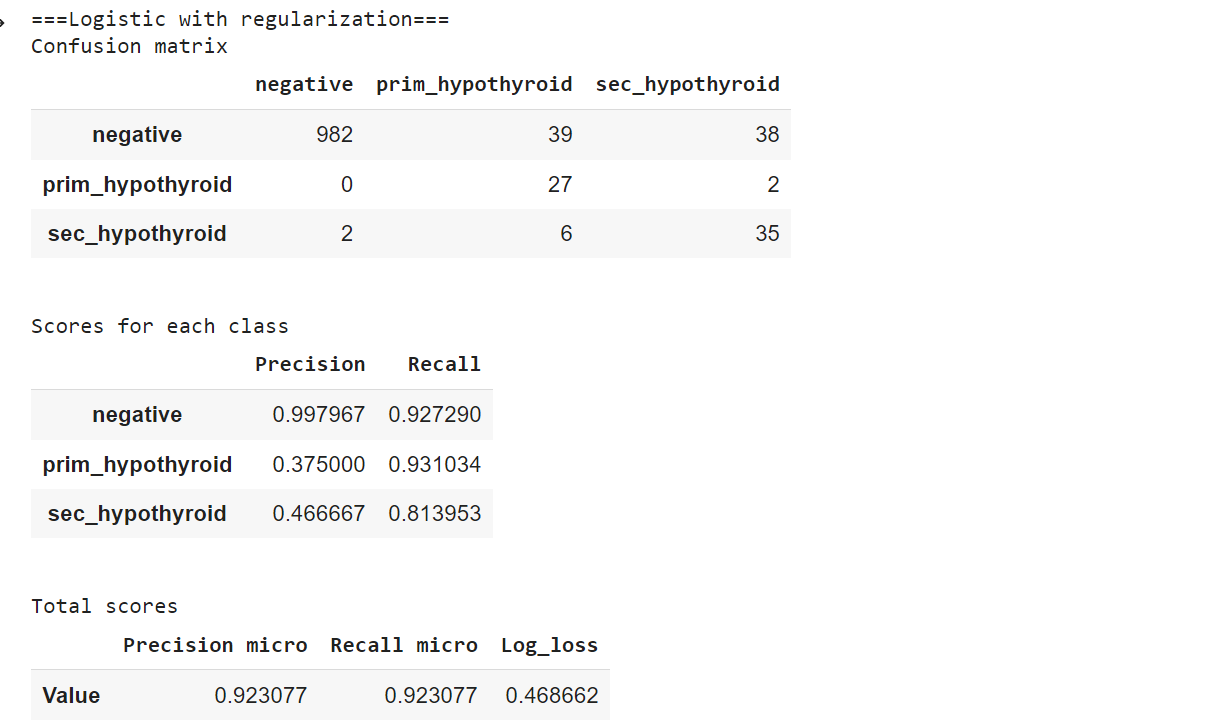

### Observations

Nets have better results than logistic regression: their confusion matrix is more "diagonal" (this fact is also represented in precision/recall table), while log regression often defines cases of illness as negative class which is  unacceptable in medical tasks. Log loss is also better for nets.

Keras net is considered to manage the task with the best results compared to other models.

# Image classification

## PyTorch

### Load and transform the data

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def evaluate_image_model(y_pred, y_true):
  df = []
  df.append(precision_score(y_true, y_pred, average=None))
  df.append(recall_score(y_true, y_pred, average=None))
  columns = pd.Series([0, 1])

  scores = pd.DataFrame(df, index=['Precision', 'Recall'], 
                        columns=columns).T

  total_scores = pd.DataFrame([precision_score(y_true, y_pred, average='micro'),
                               recall_score(y_true, y_pred, average='micro'),
                               accuracy(true, pred)],
                               index=['Precision micro', 
                                     'Recall micro',
                                      'Accuracy'],
                               columns=['Value']).T


  conf_matrix = pd.crosstab(y_true, y_pred)
  conf_matrix.columns = columns
  conf_matrix.index = columns
  return scores, total_scores, conf_matrix

In [ ]:
transform = transforms.Compose(
    [transforms.Resize((64, 64)), 
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation((0, 50)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_test = transforms.Compose(
    [transforms.Resize((64, 64)), 
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
im_train = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/hotdog_not_hotdog/hotdog__not_hotdog/train', transform=transform)
im_test = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/hotdog_not_hotdog/hotdog__not_hotdog/test', transform=transform_test)

In [ ]:
im_train_loader = torch.utils.data.DataLoader(im_train, batch_size=64, num_workers=2, shuffle=True)
im_test_loader = torch.utils.data.DataLoader(im_test, batch_size=4, num_workers=2, shuffle=True)

In [ ]:
im_train.target_transform = lambda x: 1 if x == 0 else 0
im_test.target_transform = lambda x: 1 if x == 0 else 0

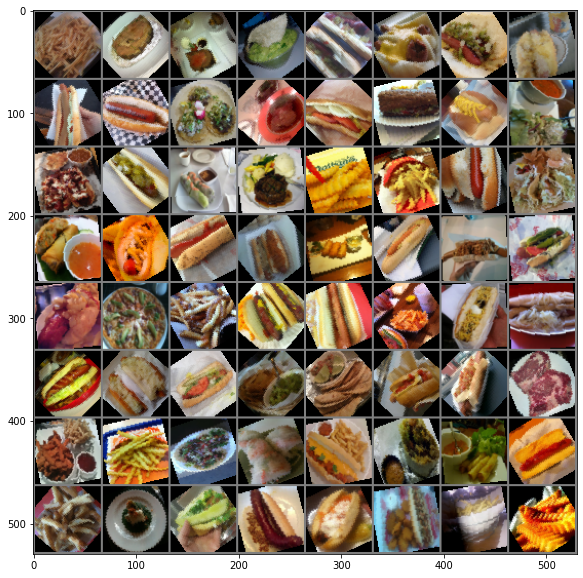

tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0])


In [ ]:
# check the data
dataiter = iter(im_train_loader)
images, labels = dataiter.next()

# show images
plt.figure(figsize=(10, 10))
out = torchvision.utils.make_grid(images)
imshow(out)
print(labels)

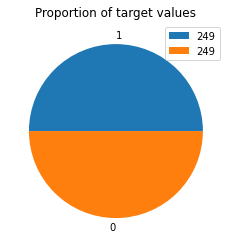

In [ ]:
pie_info = pd.Series(im_train_loader.dataset.targets).value_counts()
plt.pie(pie_info, labels=pie_info.index)
plt.title('Proportion of target values')
plt.legend(pie_info)
plt.show()

The data is balanced.

### Model - Baseline

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()#64*64
        self.conv_unit_1 = nn.Sequential(
            nn.Conv2d(3, 6, 3, 1), #62*62*6
            nn.BatchNorm2d(6),
            nn.ReLU()
        )
        self.conv_unit_2 = nn.Sequential(
            nn.Conv2d(6, 12, 5, 1), #58*58*12
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv_unit_3 = nn.Sequential(
            nn.Conv2d(12, 24, 3, 1), #29*29*24
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # 13 * 13 * 24
        )
        self.conv_unit_4 = nn.Sequential(
            nn.Conv2d(24, 48, 3, 1), #11*11*48
            nn.BatchNorm2d(48),
            nn.ReLU(),
        )

        self.lin = nn.Linear(11 * 11 * 48, 2)

    def forward(self, x):
        x = self.conv_unit_1(x)
        x = self.conv_unit_2(x)
        x = self.conv_unit_3(x)
        x = self.conv_unit_4(x)
        x = x.view(x.size(0), -1)
        x = F.softmax(self.lin(x), dim=1)                                       
        return x


img_pt_net = Net()

In [ ]:
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model
    if classname.find('Linear') != -1:
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

img_pt_net.apply(weights_init_uniform_rule) # initial weights setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(img_pt_net.parameters(), lr=0.5)

for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(im_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.float()
        labels =  labels.long()

        # forward + backward + optimize
        outputs = img_pt_net(inputs)

        loss = criterion(outputs, labels)
        loss.requres_grad = True

        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss = loss.item()   
    print('[%5d] loss: %.3f' % (epoch, running_loss))
    running_loss = 0.0

print('Finished Training')

[    0] loss: 0.784
[    1] loss: 0.742
[    2] loss: 0.695
[    3] loss: 0.586
[    4] loss: 0.667
[    5] loss: 0.624
[    6] loss: 0.637
[    7] loss: 0.634
[    8] loss: 0.689
[    9] loss: 0.622
[   10] loss: 0.538
[   11] loss: 0.558
[   12] loss: 0.622
[   13] loss: 0.564
[   14] loss: 0.436
[   15] loss: 0.544
[   16] loss: 0.534
[   17] loss: 0.543
[   18] loss: 0.511
[   19] loss: 0.580
[   20] loss: 0.546
[   21] loss: 0.446
[   22] loss: 0.601
[   23] loss: 0.589
[   24] loss: 0.511
[   25] loss: 0.536
[   26] loss: 0.568
[   27] loss: 0.517
[   28] loss: 0.500
[   29] loss: 0.497
[   30] loss: 0.604
[   31] loss: 0.420
[   32] loss: 0.535
[   33] loss: 0.431
[   34] loss: 0.503
[   35] loss: 0.520
[   36] loss: 0.398
[   37] loss: 0.456
[   38] loss: 0.510
[   39] loss: 0.470
[   40] loss: 0.426
[   41] loss: 0.365
[   42] loss: 0.537
[   43] loss: 0.386
[   44] loss: 0.527
[   45] loss: 0.461
[   46] loss: 0.368
[   47] loss: 0.439
[   48] loss: 0.460
[   49] loss: 0.554


In [ ]:
def draw_pictures_predictions(model, data_loader):
  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  model.eval()
  with torch.no_grad():
      outputs = model(images)
      pred = torch.max(outputs, 1)[1]
      # print images
      imshow(torchvision.utils.make_grid(images))
      print('Predicted: ', ' '.join('%3s' % str(list(pred)[j])
                                    for j in range(4)))
      print('Ground Truth: ', '     '.join('%5s' % str(labels.numpy()[j])
                                    for j in range(4)))

def get_labels_predicts(model, data_loader):
  true = []
  pred = []
  model.eval()
  with torch.no_grad():
      for data in data_loader:
          images, labels = data
          outputs = model(images)

          pred.extend(list(torch.max(outputs, 1)[1].detach().numpy()))
          true.extend(list(labels.numpy()))

  return pred, true

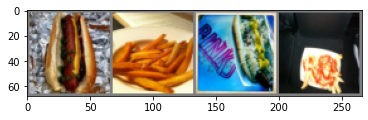

Predicted:  tensor(1) tensor(0) tensor(0) tensor(1)
Ground Truth:      1         0         1         0


In [ ]:
draw_pictures_predictions(img_pt_net, im_test_loader)

In [ ]:
pred, true = get_labels_predicts(img_pt_net, im_test_loader)

In [ ]:
scores, total_scores, conf_matrix = evaluate_image_model(pd.Series(pred), pd.Series(true))
display_scores(scores, total_scores, conf_matrix)

Confusion matrix


0    1
0  157   93
1   80  170



Scores for each class


Precision  Recall
0   0.662447   0.628
1   0.646388   0.680



Total scores


Precision micro  Recall micro  Accuracy
Value            0.654         0.654     0.654

## Pre-trained models

### AlexNet

In [ ]:
alexnet = models.alexnet(pretrained=True)

In [ ]:
alex_transform = transforms.Compose([       
 transforms.Resize(256),                    
 transforms.CenterCrop(224),                
 transforms.ToTensor(),                     
 transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225]                  
 )])

In [ ]:
alex_train = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/hotdog_not_hotdog/hotdog__not_hotdog/train', transform=alex_transform)
alex_test = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/hotdog_not_hotdog/hotdog__not_hotdog/test', transform=alex_transform)

In [ ]:
# transform target to correspondent values
alex_train.target_transform = lambda x: 1 if x == 0 else 0
alex_test.target_transform = lambda x: 1 if x == 0 else 0

In [ ]:
alex_train_loader = torch.utils.data.DataLoader(alex_train, batch_size=64, num_workers=2, shuffle=True)
alex_test_loader = torch.utils.data.DataLoader(alex_test, batch_size=4, num_workers=2, shuffle=True)

In [ ]:
# read classes explanation for alexnet to find out which class stands for hot-dogs
link = "https://gist.githubusercontent.com/ageitgey/4e1342c10a71981d0b491e1b8227328b/raw/24d78ea09a31fdff540a8494886e0051e3ad68f8/imagenet_classes.txt"
f = requests.get(link).text
classes = [line.split(', ')[1] for line in f.split('\n')[4:]]

In [ ]:
print(f"Hot-dog index: {classes.index('hotdog')}")

Hot-dog index: 934


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


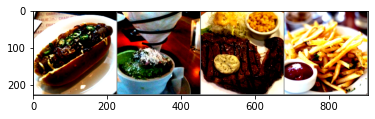

Predicted:  tensor(926) tensor(924) tensor(962) tensor(959)
Ground Truth:      1         0         0         0


In [ ]:
draw_pictures_predictions(alexnet, alex_test_loader)

In [ ]:
pred, true = get_labels_predicts(alexnet, alex_test_loader)

In [ ]:
# transform predictions to binary representation
pred = [1 if x == 934 else 0 for x in pred]

In [ ]:
scores, total_scores, conf_matrix = evaluate_image_model(pd.Series(pred), pd.Series(true))
display_scores(scores, total_scores, conf_matrix)

Confusion matrix


0    1
0  243    7
1   98  152



Scores for each class


Precision  Recall
0   0.712610   0.972
1   0.955975   0.608



Total scores


Precision micro  Recall micro  Accuracy
Value             0.79          0.79      0.79

### Alex unfreeze

In [ ]:
alexnet_tr = torchvision.models.alexnet(pretrained=True)

In [ ]:
# alexnet architecture
alexnet_tr

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# modify output layer for binary classification task
alexnet_tr.classifier[6] = nn.Linear(in_features=alexnet_tr.classifier[6].in_features, out_features=2)

In [ ]:
# unfreeze classification layers
for param in alexnet_tr.classifier.parameters():
    param.requires_grad = True

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(img_pt_net.parameters(), lr=0.0001)

for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(alex_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.float()
        labels =  labels.long()

        # forward + backward + optimize
        outputs = alexnet_tr(inputs)

        loss = criterion(outputs, labels)

        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
    running_loss = loss.item()   
    print('[%5d] loss: %.3f' % (epoch, running_loss))

print('Finished Training')

[    0] loss: 0.974
[    1] loss: 0.817
[    2] loss: 0.826
[    3] loss: 0.922
[    4] loss: 0.854
[    5] loss: 0.970
[    6] loss: 0.853
[    7] loss: 0.894
[    8] loss: 0.939
[    9] loss: 0.918
Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


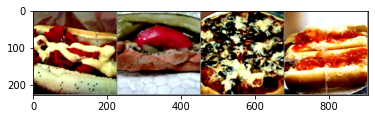

Predicted:  tensor(0) tensor(0) tensor(0) tensor(0)
Ground Truth:      1         1         0         1


In [ ]:
draw_pictures_predictions(alexnet_tr, alex_test_loader)

In [ ]:
pred, true = get_labels_predicts(alexnet_tr, alex_test_loader)

In [ ]:
scores, total_scores, conf_matrix = evaluate_image_model(pd.Series(pred), pd.Series(true))
display_scores(scores, total_scores, conf_matrix)

Confusion matrix


0   1
0  215  35
1  207  43



Scores for each class


Precision  Recall
0   0.509479   0.860
1   0.551282   0.172



Total scores


Precision micro  Recall micro  Accuracy
Value            0.516         0.516     0.516

### ResNet

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


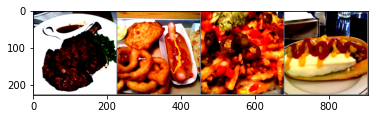

Predicted:  tensor(923) tensor(934) tensor(964) tensor(934)
Ground Truth:      0         1         0         1


In [ ]:
resnet = models.resnet101(pretrained=True)
draw_pictures_predictions(resnet, alex_test_loader)

In [ ]:
pred, true = get_labels_predicts(resnet, alex_test_loader)
pred = [1 if x == 934 else 0 for x in pred]

In [ ]:
scores, total_scores, conf_matrix = evaluate_image_model(pd.Series(pred), pd.Series(true))
display_scores(scores, total_scores, conf_matrix)

Confusion matrix


0    1
0  244    6
1   45  205



Scores for each class


Precision  Recall
0   0.844291   0.976
1   0.971564   0.820



Total scores


Precision micro  Recall micro  Accuracy
Value            0.898         0.898     0.898

### Observations

My net showed some satisfactory result with accuracy = 0.65 which is any better than a simple random where chances for luck are 50/50.

Alexnet coped better with accuracy = 0.79, however, precision for 0 class is pretty bad. Same is for 1-class recall.
My attempt to retrain Alexnet unfreezing classification layers can be considered a failure... I could not pick up any good optimizer&lr so, that it could improve loss while training.

ResNet showed the best accuracy score = 0.898. Nonetheless, 0-class precision  and 1-class recall are not great either.

## Keras

In [ ]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                      layers.RandomRotation(0.4)])

train_generator = image_dataset_from_directory(
        '/content/drive/MyDrive/hotdog_not_hotdog/hotdog__not_hotdog/train',
        image_size=(64, 64),
        batch_size=64).map(lambda x, y: (data_augmentation(x, training=True), y))


test_ds = image_dataset_from_directory(
    '/content/drive/MyDrive/hotdog_not_hotdog/hotdog__not_hotdog/test',
    image_size=(64, 64),
    batch_size=4
)

Found 498 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [ ]:
from tensorflow.keras import initializers
def build_model():
  model = keras.Sequential([
    layers.Conv2D(6, 3, (1, 1), input_shape=(64, 64, 3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(12, 5, (1, 1)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    layers.Conv2D(24, 3, (1, 1)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    layers.Conv2D(48, 3, (1, 1)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(2, activation='softmax'),
    #layers.Flatten()
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)
  return model


In [ ]:
img_krs_net = build_model()

In [ ]:
hist = img_krs_net.fit(train_generator, epochs=20)

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7ff0d3e3a170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


8/8 [==============================] - 115s 525ms/step - loss: 0.8593
Epoch 2/20
8/8 [==============================] - 5s 522ms/step - loss: 0.7503
Epoch 3/20
8/8 [==============================] - 5s 522ms/step - loss: 0.7129
Epoch 4/20
8/8 [==============================] - 5s 521ms/step - loss: 0.6792
Epoch 5/20
8/8 [==============================] - 5s 518ms/step - loss: 0.6589
Epoch 6/20
8/8 [==============================] - 5s 522ms/step - loss: 0.6621
Epoch 7/20
8/8 [==============================] - 5s 522ms/step - loss: 0.6567
Epoch 8/20
8/8 [==============================] - 5s 520ms/step - loss: 0.6313
Epoch 9/20
8/8 [==============================] - 5s 513ms/step - loss: 0.6234
Epoch 10/20
8/8 [==============================] - 5s 527ms/step - loss: 0.6379
Epoch 11/20
8/8 [==============================] - 5s 523ms/step - loss: 0.6067
Epoch 12/20
8/8 [==============================] - 5s 515ms/step - loss: 0.6204
Epoch 13/20
8/8 [==============================] - 5s 528m

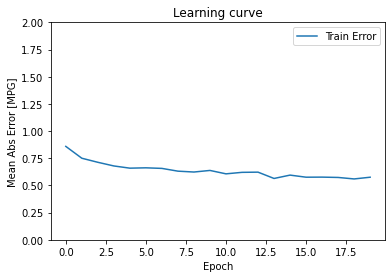

In [ ]:
plot_history(hist, y_lim=2)

In [ ]:
pred = img_krs_net.predict(test_ds)

In [ ]:
pred = [np.argmax(x) for x in pred]

In [ ]:
scores, total_scores, conf_matrix = evaluate_image_model(pd.Series(pred), pd.Series(true))
display_scores(scores, total_scores, conf_matrix)

Confusion matrix


0   1
0  181  69
1  181  69



Scores for each class


Precision  Recall
0        0.5   0.724
1        0.5   0.276



Total scores


Precision micro  Recall micro  Accuracy
Value              0.5           0.5       0.5

# Conclusion

Networks is a universal tool which can replace many classic ml algorithms. However, they are pretty greedy in term of amount of given data. So, their performance is not improved compared to other ml algorithms when dataset is not huge. 

Nonetheless, networks show excellent results after learning  on large datasets. Pretrained models prove this fact.

The flexibility of networks can be not only their advantage, but also their disadvantage. Their performance strongly depends on their hyperparameters which are difficult to pick up or theur choice could hardly be explained.